In [1]:
!which python

/work/SensingandInnovationLab/boda.s/.dep_genai/bin/python


In [2]:
import torch

torch.cuda.is_available()

True

In [27]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import random
import math
import multiprocessing
import re
import gc
from collections import defaultdict
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

import networkx as nx
from collections import Counter


import esm

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Lipinski, AllChem, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import BRICS, FragmentMatcher
from rdkit.Chem.QED import qed

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv, GATv2Conv, GraphConv, MessagePassing
from torch_geometric.data import Data, Batch
from torch_geometric.utils import to_dense_adj
import torch_scatter

from datasets import load_dataset

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## Data Download

In [4]:
os.makedirs('data', exist_ok=True)

print("Downloading dataset from Hugging Face...")
dataset = load_dataset("jglaser/binding_affinity", split="train[:200000]")

df = pd.DataFrame(dataset)
print(f"Downloaded {len(df)} samples")

df.to_parquet('data/binding_data_200k.parquet')
print("Saved dataset to data/binding_data_200k.parquet")

/work/SensingandInnovationLab/boda.s/.dep_genai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded 20000 samples
Saved dataset to data/binding_data_200k.parquet


## Protein Preprocessing using ESM-2

In [8]:
def generate_protein_embeddings(sequences, output_file, batch_size=4, max_seq_len=1022, chunk_overlap=128):
    """
    Generate and store FULL sequence embeddings (not just CLS token) for each protein
    
    For proteins longer than max_seq_len, use chunking with overlap and store the full sequence.
    """
    print("Loading ESM-2 model from Hugging Face...")
    from transformers import AutoTokenizer, AutoModel
    
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
    model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
    
    # Use GPU if available for speed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    
    all_embeddings = {}  # Dictionary to store embeddings with sequence_id as key
    sequence_ids = []
    
    # Calculate effective sequence length
    effective_len = max_seq_len - 2  # Subtract 2 for special tokens
    chunk_stride = effective_len - chunk_overlap
    
    print(f"Generating full sequence embeddings for {len(sequences)} proteins...")
    # Process sequences in batches
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i:i+batch_size]
        batch_ids = list(range(i, min(i+batch_size, len(sequences))))
        
        for j, (seq_id, sequence) in enumerate(zip(batch_ids, batch_seqs)):
            try:
                # Check if sequence needs chunking
                if len(sequence) > effective_len:
                    print(f"Sequence {seq_id} is long ({len(sequence)} > {effective_len}). Using chunking.")
                    
                    # Calculate number of chunks
                    num_chunks = max(1, int(np.ceil((len(sequence) - chunk_overlap) / chunk_stride)))
                    
                    # Store embeddings for each position in the sequence
                    full_sequence_embeddings = np.zeros((len(sequence), model.config.hidden_size))
                    
                    # Track which positions have been filled
                    position_counts = np.zeros(len(sequence))
                    
                    # Process each chunk
                    for chunk_idx in range(num_chunks):
                        # Calculate chunk start and end positions
                        start_pos = chunk_idx * chunk_stride
                        end_pos = min(start_pos + effective_len, len(sequence))
                        
                        # Get chunk sequence
                        chunk_seq = sequence[start_pos:end_pos]
                        
                        # Skip tiny chunks
                        if len(chunk_seq) < 8:
                            continue
                        
                        # Process the chunk using transformers
                        inputs = tokenizer(chunk_seq, return_tensors="pt").to(device)
                        
                        with torch.no_grad():
                            outputs = model(**inputs, output_hidden_states=True)
                        
                        # Get the last layer's hidden states, excluding special tokens
                        # [0] for batch index, [1:-1] to exclude [CLS] and [SEP] tokens
                        last_hidden_states = outputs.hidden_states[-1][0, 1:len(chunk_seq)+1, :].cpu().numpy()
                        
                        # Add to the full sequence embeddings
                        full_sequence_embeddings[start_pos:end_pos, :] += last_hidden_states
                        position_counts[start_pos:end_pos] += 1
                    
                    # Average embeddings where chunks overlapped
                    valid_positions = position_counts > 0
                    full_sequence_embeddings[valid_positions] /= position_counts[valid_positions, np.newaxis]
                    
                    # Store embeddings
                    all_embeddings[seq_id] = full_sequence_embeddings
                    sequence_ids.append(seq_id)
                
                else:
                    # For shorter sequences, process normally
                    inputs = tokenizer(sequence, return_tensors="pt").to(device)
                    
                    with torch.no_grad():
                        outputs = model(**inputs, output_hidden_states=True)
                    
                    # Extract all token embeddings (excluding special tokens)
                    last_hidden_states = outputs.hidden_states[-1][0, 1:len(sequence)+1, :].cpu().numpy()
                    
                    # Store embeddings
                    all_embeddings[seq_id] = last_hidden_states
                    sequence_ids.append(seq_id)
                
            except Exception as e:
                print(f"Error processing sequence {seq_id}: {e}")
    
    # Save to disk - using dictionary format to handle variable-length sequences
    print(f"Saving full sequence embeddings for {len(all_embeddings)} proteins to {output_file}")
    np.savez_compressed(output_file, embeddings=all_embeddings, ids=np.array(sequence_ids))
    
    return all_embeddings, sequence_ids


def process_in_chunks(parquet_file, chunk_size=5000, seq_chunk_overlap=128):
    """
    Process the dataset in chunks to avoid memory issues
    Stores full sequence embeddings for each protein
    """
    # Load the data
    df = pd.read_parquet(parquet_file)
    
    # Get unique protein sequences to avoid duplicate processing
    unique_proteins = df['seq'].unique()
    print(f"Total unique proteins: {len(unique_proteins)}")
    
    # Create processed_data directory if it doesn't exist
    os.makedirs('processed_data', exist_ok=True)
    
    # Process in chunks
    for i in range(0, len(unique_proteins), chunk_size):
        chunk_proteins = unique_proteins[i:i+chunk_size]
        output_file = f'processed_data/protein_full_embeddings_chunk_{i//chunk_size}.npz'
        
        # Skip if already processed
        if os.path.exists(output_file):
            print(f"Chunk {i//chunk_size} already processed, skipping...")
            continue
        
        # Generate embeddings for this chunk
        generate_protein_embeddings(chunk_proteins, output_file, chunk_overlap=seq_chunk_overlap)
        
        # Clear memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Create a mapping from protein sequence to its id
    protein_to_id_map = {}
    all_embeddings = {}
    processed_ids = []
    
    # Load all chunks
    for i in range(0, len(unique_proteins), chunk_size):
        chunk_file = f'processed_data/protein_full_embeddings_chunk_{i//chunk_size}.npz'
        if os.path.exists(chunk_file):
            chunk_data = np.load(chunk_file, allow_pickle=True)
            chunk_embeddings = chunk_data['embeddings'].item()  # Load the dictionary
            chunk_ids = chunk_data['ids']
            
            # Add embeddings to the combined dictionary
            for j, seq_id in enumerate(chunk_ids):
                all_embeddings[seq_id] = chunk_embeddings[seq_id]
                protein_to_id_map[unique_proteins[i + j]] = seq_id
                processed_ids.append(seq_id)
    
    # Save the combined data
    print(f"Saving combined embeddings for {len(all_embeddings)} proteins")
    np.savez_compressed('processed_data/protein_full_embeddings_all.npz', 
                         embeddings=all_embeddings, 
                         ids=np.array(processed_ids))
    
    # Save the mapping
    import pickle
    with open('processed_data/protein_to_fullembedding_map.pkl', 'wb') as f:
        pickle.dump(protein_to_id_map, f)
    
    return all_embeddings, protein_to_id_map

In [9]:
os.makedirs('processed_data', exist_ok=True)
parquet_file = 'data/binding_data_200k.parquet'
embeddings, protein_map = process_in_chunks(parquet_file)

Total unique proteins: 11795
Loading ESM-2 model from Hugging Face...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating full sequence embeddings for 5000 proteins...


 21%|██        | 260/1250 [00:57<03:27,  4.77it/s]

Sequence 1041 is long (1054 > 1020). Using chunking.


 24%|██▎       | 295/1250 [01:04<03:42,  4.29it/s]

Sequence 1180 is long (1073 > 1020). Using chunking.


 28%|██▊       | 346/1250 [01:16<04:01,  3.75it/s]

Sequence 1387 is long (1042 > 1020). Using chunking.


 30%|██▉       | 372/1250 [01:22<03:44,  3.91it/s]

Sequence 1490 is long (1342 > 1020). Using chunking.


 31%|███       | 382/1250 [01:24<03:19,  4.34it/s]

Sequence 1531 is long (1706 > 1020). Using chunking.


 41%|████      | 515/1250 [01:55<02:26,  5.03it/s]

Sequence 2062 is long (1032 > 1020). Using chunking.


 47%|████▋     | 587/1250 [02:11<02:21,  4.68it/s]

Sequence 2348 is long (1025 > 1020). Using chunking.


 52%|█████▏    | 647/1250 [02:24<02:11,  4.59it/s]

Sequence 2590 is long (1718 > 1020). Using chunking.


 58%|█████▊    | 727/1250 [02:43<02:02,  4.25it/s]

Sequence 2909 is long (1340 > 1020). Using chunking.


 59%|█████▊    | 732/1250 [02:45<01:58,  4.39it/s]

Sequence 2928 is long (1053 > 1020). Using chunking.


 60%|█████▉    | 748/1250 [02:48<01:45,  4.75it/s]

Sequence 2992 is long (1205 > 1020). Using chunking.


 61%|██████    | 758/1250 [02:51<01:49,  4.49it/s]

Sequence 3032 is long (1175 > 1020). Using chunking.


 70%|██████▉   | 873/1250 [03:17<01:13,  5.16it/s]

Sequence 3494 is long (2149 > 1020). Using chunking.


 72%|███████▏  | 896/1250 [03:23<01:20,  4.41it/s]

Sequence 3585 is long (1072 > 1020). Using chunking.


 88%|████████▊ | 1105/1250 [04:10<00:36,  3.93it/s]

Sequence 4421 is long (1287 > 1020). Using chunking.


 89%|████████▉ | 1111/1250 [04:11<00:30,  4.51it/s]

Sequence 4445 is long (1182 > 1020). Using chunking.


 95%|█████████▌| 1191/1250 [04:29<00:12,  4.66it/s]

Sequence 4764 is long (1707 > 1020). Using chunking.


100%|██████████| 1250/1250 [04:43<00:00,  4.41it/s]


Saving full sequence embeddings for 5000 proteins to processed_data/protein_full_embeddings_chunk_0.npz
Loading ESM-2 model from Hugging Face...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating full sequence embeddings for 5000 proteins...


 10%|█         | 126/1250 [00:27<04:09,  4.51it/s]

Sequence 504 is long (1283 > 1020). Using chunking.


 20%|██        | 255/1250 [00:56<03:57,  4.19it/s]

Sequence 1021 is long (1244 > 1020). Using chunking.


 30%|███       | 381/1250 [01:24<02:52,  5.03it/s]

Sequence 1524 is long (1091 > 1020). Using chunking.


 55%|█████▌    | 692/1250 [02:32<01:52,  4.95it/s]

Sequence 2771 is long (1332 > 1020). Using chunking.


 58%|█████▊    | 719/1250 [02:39<01:58,  4.49it/s]

Sequence 2877 is long (1118 > 1020). Using chunking.


 75%|███████▍  | 937/1250 [03:26<00:57,  5.41it/s]

Sequence 3749 is long (1179 > 1020). Using chunking.


 84%|████████▍ | 1053/1250 [03:52<00:43,  4.55it/s]

Sequence 4214 is long (1089 > 1020). Using chunking.
Sequence 4215 is long (1340 > 1020). Using chunking.


 86%|████████▌ | 1071/1250 [03:56<00:45,  3.95it/s]

Sequence 4285 is long (1023 > 1020). Using chunking.


 91%|█████████ | 1139/1250 [04:11<00:23,  4.77it/s]

Sequence 4556 is long (1029 > 1020). Using chunking.


100%|██████████| 1250/1250 [04:34<00:00,  4.55it/s]


Saving full sequence embeddings for 5000 proteins to processed_data/protein_full_embeddings_chunk_1.npz
Loading ESM-2 model from Hugging Face...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating full sequence embeddings for 1795 proteins...


 31%|███       | 140/449 [00:28<01:02,  4.94it/s]

Sequence 562 is long (1073 > 1020). Using chunking.


100%|██████████| 449/449 [01:33<00:00,  4.79it/s]


Saving full sequence embeddings for 1795 proteins to processed_data/protein_full_embeddings_chunk_2.npz
Saving combined embeddings for 5000 proteins


Loaded 11795 protein mappings
Loaded 5000 full sequence embeddings
ID 5 corresponds to protein: GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGAAPHP...
Embedding shape: (496, 1280) (sequence length × embedding dimension)

Found full embedding for sample protein with shape: (284, 1280)
This means we have embeddings for all 284 amino acids in the protein


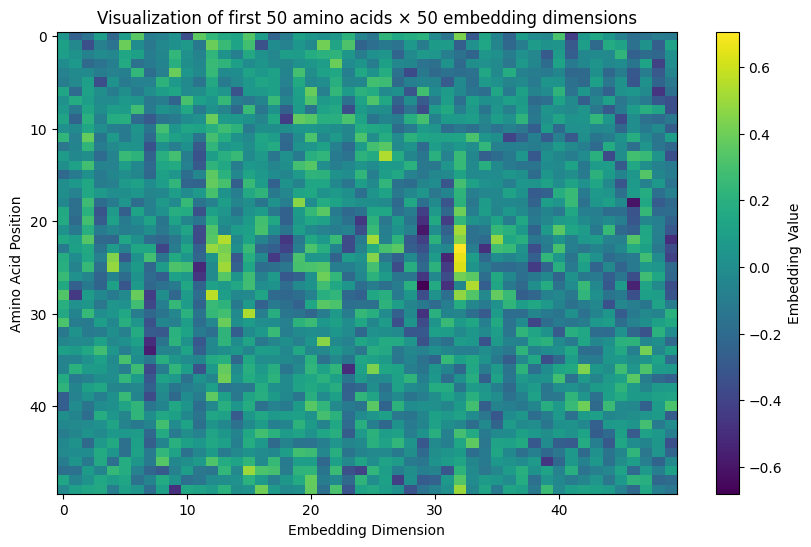

Mean embedding across positions: [ 0.01184019 -0.00657512  0.00154995  0.00653086 -0.07230945]... (showing first 5 values)
Std dev across positions: [0.14652799 0.18079527 0.17563711 0.17511298 0.18494053]... (showing first 5 values)

Found 18 proteins with sequences longer than 1000 amino acids
Min sequence length: 24
Max sequence length: 1340
Mean sequence length: 289.86


In [10]:
# Load the protein-to-full-embedding mapping
with open('processed_data/protein_to_fullembedding_map.pkl', 'rb') as f:
    protein_to_fullembedding_map = pickle.load(f)

# Load the full embeddings data
full_embeddings_data = np.load('processed_data/protein_full_embeddings_all.npz', allow_pickle=True)
all_embeddings = full_embeddings_data['embeddings'].item()  # Convert to dictionary
all_ids = full_embeddings_data['ids']

print(f"Loaded {len(protein_to_fullembedding_map)} protein mappings")
print(f"Loaded {len(all_embeddings)} full sequence embeddings")

# Example: Find which protein corresponds to a specific ID
target_id = 5
for protein_seq, seq_id in protein_to_fullembedding_map.items():
    if seq_id == target_id:
        print(f"ID {target_id} corresponds to protein: {protein_seq[:50]}...")  # Show first 50 characters
        # Show the embedding shape for this protein
        embedding = all_embeddings[target_id]
        print(f"Embedding shape: {embedding.shape} (sequence length × embedding dimension)")
        break

# Example: Get the full embedding for a specific protein sequence
def get_full_embedding_for_protein(protein_sequence, embedding_map, all_embeddings_dict):
    if protein_sequence in embedding_map:
        seq_id = embedding_map[protein_sequence]
        return all_embeddings_dict[seq_id]
    else:
        return None

# Load the original DataFrame to see some protein sequences
df = pd.read_parquet('data/binding_data_200k.parquet')
sample_protein = df['seq'].iloc[0]

# Get full embedding for this protein
sample_embedding = get_full_embedding_for_protein(sample_protein, protein_to_fullembedding_map, all_embeddings)
if sample_embedding is not None:
    print(f"\nFound full embedding for sample protein with shape: {sample_embedding.shape}")
    print(f"This means we have embeddings for all {sample_embedding.shape[0]} amino acids in the protein")
    
    # Visualize embedding dimensions
    plt.figure(figsize=(10, 6))
    plt.imshow(sample_embedding[:50, :50], aspect='auto', cmap='viridis')
    plt.title('Visualization of first 50 amino acids × 50 embedding dimensions')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Amino Acid Position')
    plt.colorbar(label='Embedding Value')
    plt.savefig('sample_protein_embedding_visualization.png')
    plt.show()
    
    # Show mean and standard deviation across positions
    pos_mean = np.mean(sample_embedding, axis=0)
    pos_std = np.std(sample_embedding, axis=0)
    print(f"Mean embedding across positions: {pos_mean[:5]}... (showing first 5 values)")
    print(f"Std dev across positions: {pos_std[:5]}... (showing first 5 values)")
else:
    print("Could not find embedding for the sample protein")

# Count how many proteins have embeddings for sequences longer than 1000 amino acids
long_proteins = 0
lengths = []
for seq_id, embedding in all_embeddings.items():
    length = embedding.shape[0]
    lengths.append(length)
    if length > 1000:
        long_proteins += 1

print(f"\nFound {long_proteins} proteins with sequences longer than 1000 amino acids")
print(f"Min sequence length: {min(lengths)}")
print(f"Max sequence length: {max(lengths)}")
print(f"Mean sequence length: {np.mean(lengths):.2f}")

## Ligand Preprocessing using RDKIT

In [3]:
# Create directory for multi-scale ligand data
os.makedirs('processed_data/ligands_multiscale_etkdg', exist_ok=True)
os.makedirs('processed_data/ligands_multiscale_etkdg/batch_results', exist_ok=True)

# Reuse existing functional groups definition
FUNCTIONAL_GROUPS = {
    'alcohol': '[OH]',
    'aldehyde': '[CX3H1](=O)[#6]',
    'ketone': '[#6][CX3](=O)[#6]',
    'carboxylic_acid': '[CX3](=O)[OX2H1]',
    'ester': '[#6][CX3](=O)[OX2][#6]',
    'amide': '[NX3][CX3](=[OX1])[#6]',
    'amine': '[NX3;H2,H1,H0;!$(NC=O)]',
    'nitrile': '[NX1]#[CX2]',
    'nitro': '[$([NX3](=O)=O),$([NX3+](=O)[O-])]',
    'sulfonic_acid': '[$([#16X4](=[OX1])(=[OX1])([#6])[OX2H,OX1H0-]),$([#16X4+2]([OX1-])([OX1-])([#6])[OX2H,OX1H0-])]',
    'sulfonamide': '[$([#16X4]([NX3])(=[OX1])(=[OX1])[#6]),$([#16X4+2]([NX3])([OX1-])([OX1-])[#6])]',
    'phosphate': '[#15,#16]=[O]',
    'halogen': '[F,Cl,Br,I]',
    'aromatic': 'a',
    'heterocycle': '[a;!c]'
}

# Define constants for physics-based features
# Average bond lengths (in Angstroms) by bond type
BOND_LENGTHS = {
    Chem.BondType.SINGLE: 1.5,  # Average C-C single bond length
    Chem.BondType.DOUBLE: 1.33, # Average C=C double bond length
    Chem.BondType.TRIPLE: 1.18, # Average C≡C triple bond length
    Chem.BondType.AROMATIC: 1.4, # Average aromatic bond length
}

def get_scaffold_hierarchy(mol):
    """
    Generate a hierarchy of scaffolds from a molecule (multi-scale level 1)
    """
    if mol is None:
        return None
    
    try:
        # Level 1: Basic Murcko scaffold (rings and linkers only)
        basic_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        basic_scaffold_smiles = Chem.MolToSmiles(basic_scaffold) if basic_scaffold else ""
        
        # Level 2: Scaffold with attachment points
        # Use BRICS fragmentation to identify potential attachment points
        fragments = list(BRICS.BRICSDecompose(mol))
        attachment_points = set()
        
        # Get atoms that would be attachment points (where fragments connect)
        for frag in fragments:
            for match in re.finditer(r'\[\d+\]', frag):
                attachment_points.add(match.group())
        
        # Level 3: Complete molecule
        complete_mol_smiles = Chem.MolToSmiles(mol)
        
        return {
            'L1_basic_scaffold': basic_scaffold_smiles,
            'L2_attachment_points': list(attachment_points),
            'L3_complete_molecule': complete_mol_smiles
        }
    except:
        return {
            'L1_basic_scaffold': "",
            'L2_attachment_points': [],
            'L3_complete_molecule': Chem.MolToSmiles(mol) if mol else ""
        }

def calc_physics_features(mol):
    """
    Calculate physics-based features using ETKDGv3 for more robust 3D structure generation
    """
    if mol is None:
        return {}
    
    physics_features = {}
    
    try:
        # Make a copy of the molecule and add hydrogens
        mol_h = Chem.AddHs(mol)
        
        # Check if molecule contains problematic atoms (metals, etc.)
        has_problematic_atoms = False
        for atom in mol_h.GetAtoms():
            if atom.GetAtomicNum() > 18 and atom.GetAtomicNum() not in [35, 53]:  # Exclude Br, I
                has_problematic_atoms = True
                break
        
        # Generate 3D coordinates using ETKDGv3
        params = AllChem.ETKDGv3()
        params.randomSeed = 42
        params.useSmallRingTorsions = True  # Better handling of small rings
        params.useBasicKnowledge = True
        params.enforceChirality = True
        params.maxIterations = 1000  # More iterations for complex structures
        
        # Skip force field for problematic molecules
        if has_problematic_atoms:
            AllChem.EmbedMolecule(mol_h, params)
            physics_features['force_field_type'] = "skipped_problematic_atoms"
            physics_features['has_problematic_atoms'] = True
        else:
            # Try embedding with ETKDGv3
            conf_id = AllChem.EmbedMolecule(mol_h, params)
            
            if conf_id >= 0:  # Successful embedding
                # Try force field optimization - MMFF94 first, UFF as fallback
                try:
                    # Try MMFF
                    results = AllChem.MMFFOptimizeMolecule(mol_h, maxIters=200, 
                                                          confId=0, ignoreInterfragInteractions=False)
                    if results == 0:  # Successful optimization
                        ff_type = "MMFF"
                        # Get energy
                        mp = AllChem.MMFFGetMoleculeProperties(mol_h)
                        ff = AllChem.MMFFGetMoleculeForceField(mol_h, mp)
                        if ff:
                            physics_features['total_energy'] = ff.CalcEnergy()
                    else:
                        raise Exception("MMFF optimization failed")
                except:
                    try:
                        # Fall back to UFF
                        AllChem.UFFOptimizeMolecule(mol_h, maxIters=200, confId=0)
                        ff_type = "UFF"
                        # Get energy
                        ff = AllChem.UFFGetMoleculeForceField(mol_h)
                        if ff:
                            physics_features['total_energy'] = ff.CalcEnergy()
                    except:
                        ff_type = "failed"
                        physics_features['total_energy'] = 0.0
                
                physics_features['force_field_type'] = ff_type
            else:
                # If embedding fails, use a simpler approach
                physics_features['force_field_type'] = "embedding_failed"
        
        # Get ring strain information - this doesn't depend on 3D structure
        ring_info = mol.GetRingInfo()
        ring_sizes = [len(ring) for ring in ring_info.AtomRings()]
        
        # Calculate strain based on ring size
        ring_strains = []
        for size in ring_sizes:
            if size == 3:
                strain = 5.0  # High strain for 3-membered rings
            elif size == 4:
                strain = 3.0  # High strain for 4-membered rings
            elif size == 5 or size == 6:
                strain = 0.1  # Low strain for 5/6-membered rings
            else:
                strain = 1.0  # Medium strain for other ring sizes
            
            ring_strains.append(strain)
        
        if ring_strains:
            physics_features['avg_ring_strain'] = sum(ring_strains) / len(ring_strains)
            physics_features['total_ring_strain'] = sum(ring_strains)
            physics_features['ring_count'] = len(ring_strains)
            physics_features['ring_sizes'] = ring_sizes
        else:
            physics_features['avg_ring_strain'] = 0.0
            physics_features['total_ring_strain'] = 0.0
            physics_features['ring_count'] = 0
            physics_features['ring_sizes'] = []
        
    except Exception as e:
        # If anything fails, provide default values
        physics_features = {
            'force_field_type': 'exception',
            'error_message': str(e),
            'total_energy': 0.0,
            'avg_ring_strain': 0.0,
            'total_ring_strain': 0.0,
            'ring_count': mol.GetRingInfo().NumRings() if mol else 0,
            'ring_sizes': []
        }
    
    return physics_features

def get_molecular_graph(mol):
    """
    Extract the molecular graph representation with detailed atom and bond features
    """
    if mol is None:
        return {'atoms': [], 'bonds': []}
    
    # Get ring information - use the proper RDKit method
    ring_info = mol.GetRingInfo()
    atom_rings = defaultdict(list)
    bond_rings = defaultdict(list)
    
    # Map atoms to the rings they belong to
    for ring_idx, ring in enumerate(ring_info.AtomRings()):
        ring_size = len(ring)
        for atom_idx in ring:
            atom_rings[atom_idx].append(ring_size)
    
    # Map bonds to the rings they belong to
    for ring_idx, ring in enumerate(ring_info.BondRings()):
        ring_size = len(ring)
        for bond_idx in ring:
            bond_rings[bond_idx].append(ring_size)
    
    # Process atoms
    atoms = []
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_features = {
            'atomic_num': atom.GetAtomicNum(),
            'formal_charge': atom.GetFormalCharge(),
            'hybridization': int(atom.GetHybridization()),
            'aromatic': int(atom.GetIsAromatic()),
            'num_h': atom.GetTotalNumHs(),
            'degree': atom.GetDegree(),
            'chirality': int(atom.GetChiralTag()),
            'is_in_ring': int(atom.IsInRing()),
            'ring_sizes': sorted(atom_rings[atom_idx]),
            'valence': atom.GetTotalValence()
        }
        atoms.append(atom_features)
    
    # Process bonds
    bonds = []
    for bond in mol.GetBonds():
        bond_idx = bond.GetIdx()
        bond_features = {
            'start_atom': bond.GetBeginAtomIdx(),
            'end_atom': bond.GetEndAtomIdx(),
            'bond_type': int(bond.GetBondType()),
            'is_conjugated': int(bond.GetIsConjugated()),
            'is_aromatic': int(bond.GetIsAromatic()),
            'is_in_ring': int(bond.IsInRing()),
            'stereo': int(bond.GetStereo()),
            'ring_sizes': sorted(bond_rings[bond_idx])
        }
        bonds.append(bond_features)
    
    return {'atoms': atoms, 'bonds': bonds}

def process_smiles_batch_multiscale(args):
    """
    Process a batch of SMILES strings to generate multi-scale ligand representations
    """
    smiles_batch, batch_idx, chunkify = args
    start_time = time.time()
    ligand_data = {}
    
    print(f"Worker {multiprocessing.current_process().name} processing batch {batch_idx} with {len(smiles_batch)} SMILES for multi-scale")
    
    # Process molecules in smaller chunks to save intermediate results
    if chunkify:
        chunk_size = 10  # Process 10 molecules at a time
        for i in range(0, len(smiles_batch), chunk_size):
            chunk = smiles_batch[i:i+chunk_size]
            chunk_start = time.time()
            print(f"  Worker {multiprocessing.current_process().name} processing chunk {i//chunk_size} of batch {batch_idx}")
            
            for smiles in chunk:
                try:
                    # Convert SMILES to RDKit molecule
                    mol = Chem.MolFromSmiles(smiles)
                    
                    if mol is None:
                        print(f"Failed to parse SMILES: {smiles}")
                        continue

                    

                    
                    # Process molecule as before...
                    # 1. Generate scaffold hierarchy
                    scaffolds = get_scaffold_hierarchy(mol)
                    
                    # 2. Generate basic molecular properties
                    properties = {}
                    properties['molecular_weight'] = Descriptors.MolWt(mol)
                    properties['logp'] = Descriptors.MolLogP(mol)
                    properties['h_donors'] = Descriptors.NumHDonors(mol)
                    properties['h_acceptors'] = Descriptors.NumHAcceptors(mol)
                    properties['rotatable_bonds'] = Descriptors.NumRotatableBonds(mol)
                    properties['tpsa'] = Descriptors.TPSA(mol)
                    properties['qed'] = qed(mol)
                    properties['heavy_atom_count'] = Descriptors.HeavyAtomCount(mol)
                    properties['ring_count'] = Descriptors.RingCount(mol)
                    properties['aromatic_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
                    properties['fraction_sp3'] = rdMolDescriptors.CalcFractionCSP3(mol)
                    properties['num_stereocenters'] = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
                    
                    # 3. Identify functional groups
                    functional_groups = {}
                    for group_name, smarts in FUNCTIONAL_GROUPS.items():
                        pattern = Chem.MolFromSmarts(smarts)
                        if pattern:
                            matches = mol.GetSubstructMatches(pattern)
                            functional_groups[group_name] = len(matches)
                    
                    # 4. Calculate physics-based features
                    physics_features = calc_physics_features(mol)
                    
                    # 5. Get molecular graph representation
                    graph = get_molecular_graph(mol)
                    
                    # 6. Decompose into fragments for multi-scale representation
                    # Level 1: Bemis-Murcko scaffold
                    scaffold_mol = MurckoScaffold.GetScaffoldForMol(mol)
                    level1_graph = get_molecular_graph(scaffold_mol) if scaffold_mol else {'atoms': [], 'bonds': []}
                    
                    # Level 2: Find functional group attachment points
                    level2_fragments = []
                    try:
                        brics_fragments = list(BRICS.BRICSDecompose(mol))
                        for frag_smiles in brics_fragments:
                            frag_mol = Chem.MolFromSmiles(frag_smiles)
                            if frag_mol:
                                frag_graph = get_molecular_graph(frag_mol)
                                level2_fragments.append({
                                    'smiles': frag_smiles,
                                    'graph': frag_graph
                                })
                    except Exception as e:
                        # If fragment decomposition fails, just log and continue
                        pass
                    
                    # 7. Create multi-scale representation
                    multi_scale = {
                        'level1_scaffold': {
                            'smiles': Chem.MolToSmiles(scaffold_mol) if scaffold_mol else "",
                            'graph': level1_graph
                        },
                        'level2_fragments': level2_fragments,
                        'level3_complete': {
                            'smiles': smiles,
                            'graph': graph
                        }
                    }
                    
                    # Store all data
                    ligand_data[smiles] = {
                        'properties': properties,
                        'functional_groups': functional_groups,
                        'physics_features': physics_features,
                        'multi_scale': multi_scale
                    }
                    
                except Exception as e:
                    print(f"Error processing SMILES {smiles} for multi-scale: {str(e)}")
            
            chunk_end = time.time()
            print(f"  Chunk {i//chunk_size} of batch {batch_idx} completed in {chunk_end - chunk_start:.2f} seconds")
    else:
        # Non-chunked processing (same as original code)
        for smiles in smiles_batch:
            try:
                # Convert SMILES to RDKit molecule
                print("Started", smiles)
                mol = Chem.MolFromSmiles(smiles)
                
                if mol is None:
                    print(f"Failed to parse SMILES: {smiles}")
                    continue

                # Skip very large ligands
                if mol.GetNumAtoms() > 150:
                    print(f"Skipping {smiles} due to large size ({mol.GetNumAtoms()} atoms)")
                    continue

                print("Length", mol.GetNumAtoms())
                # Process molecule as in the chunked version...
                # 1. Generate scaffold hierarchy
                scaffolds = get_scaffold_hierarchy(mol)
                print("scaffolds Done")
                
                # 2. Generate basic molecular properties
                properties = {}
                properties['molecular_weight'] = Descriptors.MolWt(mol)
                properties['logp'] = Descriptors.MolLogP(mol)
                properties['h_donors'] = Descriptors.NumHDonors(mol)
                properties['h_acceptors'] = Descriptors.NumHAcceptors(mol)
                properties['rotatable_bonds'] = Descriptors.NumRotatableBonds(mol)
                properties['tpsa'] = Descriptors.TPSA(mol)
                properties['qed'] = qed(mol)
                properties['heavy_atom_count'] = Descriptors.HeavyAtomCount(mol)
                properties['ring_count'] = Descriptors.RingCount(mol)
                properties['aromatic_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
                properties['fraction_sp3'] = rdMolDescriptors.CalcFractionCSP3(mol)
                properties['num_stereocenters'] = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))

                print("properties Done")
                # 3. Identify functional groups
                functional_groups = {}
                for group_name, smarts in FUNCTIONAL_GROUPS.items():
                    pattern = Chem.MolFromSmarts(smarts)
                    if pattern:
                        matches = mol.GetSubstructMatches(pattern)
                        functional_groups[group_name] = len(matches)
                print("functional_groups Done")
                # 4. Calculate physics-based features
                physics_features = calc_physics_features(mol)
                print("physics_features Done")
                # 5. Get molecular graph representation
                graph = get_molecular_graph(mol)
                print("graph done")
                
                # 6. Decompose into fragments for multi-scale representation
                # Level 1: Bemis-Murcko scaffold
                scaffold_mol = MurckoScaffold.GetScaffoldForMol(mol)
                level1_graph = get_molecular_graph(scaffold_mol) if scaffold_mol else {'atoms': [], 'bonds': []}
                print("Multi Scale L1 Done")
                # Level 2: Find functional group attachment points
                level2_fragments = []
                try:
                    brics_fragments = list(BRICS.BRICSDecompose(mol))
                    for frag_smiles in brics_fragments:
                        frag_mol = Chem.MolFromSmiles(frag_smiles)
                        if frag_mol:
                            frag_graph = get_molecular_graph(frag_mol)
                            level2_fragments.append({
                                'smiles': frag_smiles,
                                'graph': frag_graph
                            })
                except Exception as e:
                    # If fragment decomposition fails, just log and continue
                    pass
                print("Multi Scale L2 Done")
                # 7. Create multi-scale representation
                multi_scale = {
                    'level1_scaffold': {
                        'smiles': Chem.MolToSmiles(scaffold_mol) if scaffold_mol else "",
                        'graph': level1_graph
                    },
                    'level2_fragments': level2_fragments,
                    'level3_complete': {
                        'smiles': smiles,
                        'graph': graph
                    }
                }
                
                # Store all data
                ligand_data[smiles] = {
                    'properties': properties,
                    'functional_groups': functional_groups,
                    'physics_features': physics_features,
                    'multi_scale': multi_scale
                }
                print("Completed", smiles)
                
            except Exception as e:
                print(f"Error processing SMILES {smiles} for multi-scale: {str(e)}")
    
    end_time = time.time()
    print(f"Worker completed multi-scale batch {batch_idx} in {end_time - start_time:.2f} seconds")
    return ligand_data

def generate_multiscale_ligand_representations(parquet_file, output_dir, batch_size=100, n_jobs=8, chunkify=True):
    """
    Generate multi-scale graph-based representations with SMILES-level resumption capability
    """
    # Create directories
    batch_dir = os.path.join(output_dir, 'batch_results')
    os.makedirs(batch_dir, exist_ok=True)
    
    # Path for our SMILES mapping file
    smiles_map_file = os.path.join(output_dir, 'processed_smiles_map.pkl')
    
    # Load existing SMILES map if it exists
    processed_smiles = {}
    if os.path.exists(smiles_map_file):
        try:
            with open(smiles_map_file, 'rb') as f:
                processed_smiles = pickle.load(f)
            print(f"Found mapping file with {len(processed_smiles)} already processed SMILES")
        except Exception as e:
            print(f"Error loading existing SMILES map: {e}")
            processed_smiles = {}
    
    # Find the highest existing batch index to avoid overwriting
    highest_batch_idx = -1
    if processed_smiles:
        highest_batch_idx = max(processed_smiles.values())
    print(f"Highest existing batch index: {highest_batch_idx}")
    
    print("Loading dataset...")
    df = pd.read_parquet(parquet_file)
    
    # Get unique ligands
    unique_smiles = df['smiles'].unique()
    print(f"Total unique ligands: {len(unique_smiles)}")
    
    # Filter out already processed SMILES
    smiles_to_process = [s for s in unique_smiles if s not in processed_smiles]
    print(f"SMILES remaining to process: {len(smiles_to_process)}")
    
    # Split remaining SMILES into batches
    num_batches = (len(smiles_to_process) + batch_size - 1) // batch_size
    smiles_batches = [smiles_to_process[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    
    # Track the next available batch index
    next_batch_idx = highest_batch_idx + 1
    
    # Process remaining batches
    for batch_group_idx in range(0, len(smiles_batches), n_jobs):
        # Prepare current set of batch arguments
        current_batch_args = []
        for i in range(batch_group_idx, min(batch_group_idx + n_jobs, len(smiles_batches))):
            # Use a new unique batch index for each batch
            current_batch_idx = next_batch_idx
            next_batch_idx += 1
            current_batch_args.append((smiles_batches[i], current_batch_idx, chunkify))
        
        with multiprocessing.Pool(processes=len(current_batch_args)) as pool:
            # Process current batches
            batch_results = list(tqdm(
                pool.imap(process_smiles_batch_multiscale, current_batch_args),
                total=len(current_batch_args),
                desc=f"Processing batch group {batch_group_idx//n_jobs + 1}/{(len(smiles_batches) + n_jobs - 1)//n_jobs}"
            ))
        
        # Save results and update SMILES map
        for i, batch_result in enumerate(batch_results):
            batch_idx = current_batch_args[i][1]  # Get the batch index from arguments
            batch_file = os.path.join(batch_dir, f'batch_{batch_idx}.pkl')
            
            # Save batch results
            with open(batch_file, 'wb') as f:
                pickle.dump(batch_result, f)
            
            # Update the SMILES map with newly processed SMILES
            for smiles in batch_result.keys():
                processed_smiles[smiles] = batch_idx
            
            print(f"Saved batch {batch_idx} with {len(batch_result)} ligands")
        
        # Save updated SMILES map after each batch group
        with open(smiles_map_file, 'wb') as f:
            pickle.dump(processed_smiles, f)
        
        # Clear memory
        batch_results = None
        gc.collect()
        try:
            print("Clearing memory...")
            import ctypes
            ctypes.cdll.LoadLibrary('libc.so.6')
            ctypes.CDLL('libc.so.6').malloc_trim(0)
        except:
            pass
    
    # Combine all results
    if len(processed_smiles) > 0:
        print("Combining all batch results...")
        
        # Get all batch files based on the SMILES mapping
        batch_indices = set(processed_smiles.values())
        batch_files = [os.path.join(batch_dir, f'batch_{idx}.pkl') for idx in batch_indices]
        
        combined_ligand_data = {}
        
        for batch_file in tqdm(batch_files, desc="Loading batch files"):
            try:
                with open(batch_file, 'rb') as f:
                    batch_data = pickle.load(f)
                    combined_ligand_data.update(batch_data)
            except Exception as e:
                print(f"Error loading batch file {batch_file}: {str(e)}")
        
        # Save the final combined data
        final_file = os.path.join(output_dir, 'ligand_multiscale_etkdg_representations.pkl')
        with open(final_file, 'wb') as f:
            pickle.dump(combined_ligand_data, f)
        
        print(f"Saved multi-scale representations for {len(combined_ligand_data)} ligands to {final_file}")
    
    return processed_smiles

In [5]:
parquet_file = 'data/binding_data_200k.parquet'
output_dir = "processed_data/ligands_multiscale_etkdg"

generate_multiscale_ligand_representations(
    parquet_file=parquet_file,
    output_dir=output_dir,
    batch_size=5,
    n_jobs=10,
    chunkify=False
)

Found mapping file with 16525 already processed SMILES
Highest existing batch index: 3979
Loading dataset...
Total unique ligands: 16536
SMILES remaining to process: 11


Processing batch group 1/1:   0%|          | 0/3 [00:00<?, ?it/s]

Worker ForkPoolWorker-625 processing batch 3982 with 1 SMILES for multi-scaleWorker ForkPoolWorker-624 processing batch 3981 with 5 SMILES for multi-scaleWorker ForkPoolWorker-623 processing batch 3980 with 5 SMILES for multi-scale


StartedStartedStarted   [NH3+]CCCC[C@@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)O)CC(=O)O)C)Cc1ccc(cc1)O)CC(C)C)CC(C)C)CCC(=O)O)CCSC)CCC(=O)N)[C@H](O)C)[C@H](O)C)[C@H](O)C)CCCNC(=N)N)CCCNC(=N)N)CCCNC(=N)N)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H]1[NH2+]CCC1)CCCC[NH3+])CC(=O)N[NH3+]CCCC[C@@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)O)CCSC)[C@H](CC)C)CC(=O)O)Cc1ccccc1)CC(C)C)CC(=O)O)[C@H](O)C)C(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H]([C@H](O)C)[NH3+])CCSC)CCC(=O)O)CC(=O)N

Processing batch group 1/1: 100%|██████████| 3/3 [00:00<00:00, 113.65it/s]

Saved batch 3980 with 0 ligands
Saved batch 3981 with 0 ligands
Saved batch 3982 with 0 ligands


Clearing memory...
Combining all batch results...


Loading batch files: 100%|██████████| 3975/3975 [00:13<00:00, 290.79it/s]


Saved multi-scale representations for 16525 ligands to processed_data/ligands_multiscale_etkdg/ligand_multiscale_etkdg_representations.pkl


{'CCCCCCCCCCCCCCCCCCCC(=O)O': 0,
 'OC[C@H]1O[C@H](Oc2cccc(c2)N(=O)=O)[C@@H]([C@H]([C@H]1O)O)O': 1,
 'COc1ccc(cc1)c1c(onc1c1cc(C(C)C)c(cc1O)O)NC(=O)C1=CC1': 2,
 'OC[C@@H](C(=O)N[C@@H]([C@H](CC)C)C(=O)O)NC(=O)[C@H](CC1=CN=C2[C@@H]1C=CC=C2)NC(=O)[C@H](CC(=O)O)[NH3+]': 3,
 'CO[C@@H]1[C@H](O[C@H]([C@@H]1O)n1ccc(=O)[nH]c1=O)[C@H](C(=O)N)O[C@H]1OC(=C[C@@H]([C@@H]1O)O)C(=O)N[C@H]1CCCCNC1=O': 4,
 'OC(=O)[C@@H](NC1=NC(C)(C)Cc2c1cccc2)Cc1ccccc1': 5,
 'Cc1ccc(cc1c1ccc2c(c1)[nH]c(=O)n2C)NC(=O)c1cccc(c1)C(F)(F)F': 6,
 'O[C@H]1O[C@H](COP(=O)(O)O)[C@H]([C@H]([C@H]1O)O)O': 7,
 'CC[C@@H]([C@@H](C(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)O)CC(=O)N)[C@H](CC)C)Cc1ccc(cc1)O)[C@H](O)C)[C@H](O)C)C(C)C)NC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)[NH3+])CC(=O)N)C': 8,
 'OCC[C@@H]1CCCCN1c1cc(NCC2=CC=CN(C2)O)n2c(n1)c(CC)cn2': 9,
 'CCO[C@H](C(=O)O)Cc1ccc(cc1)OCCc1ccc(cc1)OS(=O)(=O)C': 10,
 'O[C@@H]1[C@@H](COS(=O)(=O)NC(=O)[C@@H]2CCC[NH2+]2)O[C@H]([C@@H]1O)n1cnc2c1ncn

## Combined Dataset

In [6]:
def create_multiscale_combined_dataset(parquet_file, protein_embedding_file, protein_map_file, 
                                       ligand_data_file, output_file, use_full_sequence=True,
                                       max_protein_length=1000):
    """
    Create a combined dataset linking proteins and multi-scale ligand representations
    with binding affinities for the graph-based diffusion model
    
    Args:
        parquet_file: Path to original data with protein-ligand pairs and affinity values
        protein_embedding_file: Path to protein embeddings .npz file
        protein_map_file: Path to protein sequence to embedding index mapping
        ligand_data_file: Path to multi-scale ligand representations file
        output_file: Path to save the combined dataset
        use_full_sequence: Whether to use full sequence embeddings (True) or CLS token embeddings (False)
        max_protein_length: Maximum protein sequence length to include (for memory efficiency)
    """
    print("Loading data sources...")
    
    # Load original data with protein-ligand pairs
    df = pd.read_parquet(parquet_file)
    print(f"Loaded {len(df)} protein-ligand pairs from original dataset")
    
    # Load protein embeddings
    print(f"Loading protein embeddings from {protein_embedding_file}...")
    if use_full_sequence:
        protein_data = np.load(protein_embedding_file, allow_pickle=True)
        protein_embeddings = protein_data['embeddings'].item()  # Dictionary for full sequence
        print(f"Loaded full sequence embeddings for {len(protein_embeddings)} proteins")
    else:
        protein_data = np.load(protein_embedding_file)
        protein_embeddings = protein_data['embeddings']  # Array for CLS token
        print(f"Loaded CLS token embeddings with shape {protein_embeddings.shape}")
    
    # Load protein mapping
    print(f"Loading protein mapping from {protein_map_file}...")
    with open(protein_map_file, 'rb') as f:
        protein_to_idx = pickle.load(f)
    print(f"Loaded mapping for {len(protein_to_idx)} proteins")
    
    # Load ligand multi-scale representations
    print(f"Loading ligand representations from {ligand_data_file}...")
    with open(ligand_data_file, 'rb') as f:
        ligand_data = pickle.load(f)
    print(f"Loaded multi-scale representations for {len(ligand_data)} ligands")
    
    # Create combined dataset
    print("Creating combined multi-scale dataset...")
    combined_data = []
    
    # Counters for stats
    missing_protein = 0
    missing_ligand = 0
    filtered_ligand = 0
    successful_pairs = 0
    truncated_proteins = 0
    
    # Process each protein-ligand pair
    for _, row in tqdm(df.iterrows(), total=len(df)):
        protein_seq = row['seq']
        ligand_smiles = row['smiles']
        
        # Get affinity values - use normalized affinity if available
        if 'neg_log10_affinity_M' in row:
            affinity = row['neg_log10_affinity_M']
        elif 'affinity' in row:
            affinity = row['affinity']
        else:
            affinity = 0.0
        
        # Skip if protein not in our processed data
        if protein_seq not in protein_to_idx:
            missing_protein += 1
            continue
        
        # Skip if ligand not in our processed data
        if ligand_smiles not in ligand_data:
            # Check if it was filtered due to size or just missing
            mol = Chem.MolFromSmiles(ligand_smiles) if 'Chem' in globals() else None
            if mol and mol.GetNumAtoms() > 150:
                filtered_ligand += 1
            else:
                missing_ligand += 1
            continue
        
        # Get protein embedding
        if use_full_sequence:
            # For full sequence embeddings
            protein_idx = protein_to_idx[protein_seq]
            protein_embedding = protein_embeddings[protein_idx]
            
            # Truncate if too long (for memory efficiency)
            if len(protein_embedding) > max_protein_length:
                protein_embedding = protein_embedding[:max_protein_length]
                truncated_proteins += 1
        else:
            # For CLS token embeddings
            protein_idx = protein_to_idx[protein_seq]
            protein_embedding = protein_embeddings[protein_idx]
        
        # Get ligand multi-scale representation
        ligand_repr = ligand_data[ligand_smiles]
        
        # Create entry linking everything
        entry = {
            # Protein data
            'protein_embedding': protein_embedding,
            'protein_seq': protein_seq,
            'protein_length': len(protein_embedding) if use_full_sequence else protein_embeddings.shape[1],
            
            # Binding data
            'affinity': affinity,
            
            # Ligand data
            'ligand_smiles': ligand_smiles,
            'multi_scale': ligand_repr['multi_scale'],
            'properties': ligand_repr['properties'],
            'functional_groups': ligand_repr['functional_groups'],
            'physics_features': ligand_repr['physics_features'],
        }
        
        combined_data.append(entry)
        successful_pairs += 1
    
    print(f"Created combined multi-scale dataset with {len(combined_data)} entries")
    print(f"Stats: {successful_pairs} successful pairs")
    print(f"       {missing_protein} missing proteins")
    print(f"       {missing_ligand} missing ligands")
    print(f"       {filtered_ligand} filtered ligands (>150 atoms)")
    if use_full_sequence:
        print(f"       {truncated_proteins} truncated proteins (>{max_protein_length} residues)")
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save the combined dataset
    print(f"Saving combined dataset to {output_file}...")
    with open(output_file, 'wb') as f:
        pickle.dump(combined_data, f)
    
    print(f"Saved combined multi-scale dataset with {len(combined_data)} entries")
    
    # Calculate some statistics about the dataset
    if len(combined_data) > 0:
        print("\nDataset Statistics:")
        
        # Affinity distribution
        affinities = [entry['affinity'] for entry in combined_data]
        print(f"Affinity range: {min(affinities):.2f} to {max(affinities):.2f}")
        print(f"Mean affinity: {np.mean(affinities):.2f}")
        
        # Protein sequence lengths
        if use_full_sequence:
            protein_lengths = [len(entry['protein_embedding']) for entry in combined_data]
            print(f"Protein length range: {min(protein_lengths)} to {max(protein_lengths)} residues")
            print(f"Mean protein length: {np.mean(protein_lengths):.2f} residues")
        
        # Ligand statistics
        mol_weights = [entry['properties']['molecular_weight'] for entry in combined_data]
        print(f"Molecular weight range: {min(mol_weights):.2f} to {max(mol_weights):.2f}")
        print(f"Mean molecular weight: {np.mean(mol_weights):.2f}")
        
        # Graph statistics
        atom_counts = [len(entry['multi_scale']['level3_complete']['graph']['atoms']) for entry in combined_data]
        print(f"Atom count range: {min(atom_counts)} to {max(atom_counts)} atoms")
        print(f"Mean atom count: {np.mean(atom_counts):.2f} atoms")
    
    return combined_data

In [7]:
parquet_file = 'data/binding_data_200k.parquet'

# Protein embedding files (use full sequence embeddings)
protein_embedding_file = 'processed_data/protein_full_embeddings_all.npz'
protein_map_file = 'processed_data/protein_to_fullembedding_map.pkl'

# Multi-scale ligand representation file
ligand_data_file = 'processed_data/ligands_multiscale_etkdg/ligand_multiscale_etkdg_representations.pkl'

# Output path for the combined dataset
output_file = 'processed_data/combined_multiscale_dataset.pkl'

# Create the combined dataset
combined_data = create_multiscale_combined_dataset(
    parquet_file=parquet_file,
    protein_embedding_file=protein_embedding_file,
    protein_map_file=protein_map_file,
    ligand_data_file=ligand_data_file,
    output_file=output_file,
    use_full_sequence=True,  # Use full sequence embeddings
    max_protein_length=1000  # Limit protein length for memory efficiency
)

print(f"Combined multi-scale dataset created with {len(combined_data)} protein-ligand pairs")

Loading data sources...
Loaded 20000 protein-ligand pairs from original dataset
Loading protein embeddings from processed_data/protein_full_embeddings_all.npz...
Loaded full sequence embeddings for 5000 proteins
Loading protein mapping from processed_data/protein_to_fullembedding_map.pkl...
Loaded mapping for 11795 proteins
Loading ligand representations from processed_data/ligands_multiscale_etkdg/ligand_multiscale_etkdg_representations.pkl...
Loaded multi-scale representations for 16525 ligands
Creating combined multi-scale dataset...


100%|██████████| 20000/20000 [00:02<00:00, 8550.89it/s] 


Created combined multi-scale dataset with 19989 entries
Stats: 19989 successful pairs
       0 missing proteins
       0 missing ligands
       11 filtered ligands (>150 atoms)
       85 truncated proteins (>1000 residues)
Saving combined dataset to processed_data/combined_multiscale_dataset.pkl...
Saved combined multi-scale dataset with 19989 entries

Dataset Statistics:
Affinity range: 0.40 to 15.00
Mean affinity: 6.43
Protein length range: 24 to 1000 residues
Mean protein length: 280.66 residues
Molecular weight range: 57.89 to 2498.03
Mean molecular weight: 483.83
Atom count range: 4 to 177 atoms
Mean atom count: 33.62 atoms
Combined multi-scale dataset created with 19989 protein-ligand pairs


## EDA

In [9]:
# Create output directory for visualizations
os.makedirs('visualizations/multiscale', exist_ok=True)

# Load the multi-scale combined dataset
print("Loading multi-scale combined dataset...")
with open('processed_data/combined_multiscale_dataset.pkl', 'rb') as f:
    combined_data = pickle.load(f)

# Basic information about the dataset
print(f"Dataset size: {len(combined_data)} protein-ligand pairs")

# Examine one sample in detail
sample = combined_data[0]
print("\nKeys in each data entry:")
for key in sample.keys():
    print(f"- {key}")

print("\nMulti-scale representation levels:")
for key in sample['multi_scale'].keys():
    print(f"- {key}")

# Check shapes of important data elements
print("\nData shapes:")
print(f"Protein embedding shape: {np.array(sample['protein_embedding']).shape}")
print(f"Atoms in ligand graph: {len(sample['multi_scale']['level3_complete']['graph']['atoms'])}")
print(f"Bonds in ligand graph: {len(sample['multi_scale']['level3_complete']['graph']['bonds'])}")
print(f"Number of fragments: {len(sample['multi_scale']['level2_fragments'])}")

# Distribution of affinity values
affinities = [item['affinity'] for item in combined_data]
plt.figure(figsize=(10, 6))
sns.histplot(affinities, bins=50, kde=True)
plt.title('Distribution of Binding Affinity Values')
plt.xlabel('Affinity (-log10[M])')
plt.ylabel('Count')
plt.savefig('visualizations/multiscale/affinity_distribution.png')
plt.close()

# Analyze protein sequences
protein_lengths = [len(item['protein_seq']) for item in combined_data]
plt.figure(figsize=(10, 6))
sns.histplot(protein_lengths, bins=50, kde=True)
plt.title('Distribution of Protein Sequence Lengths')
plt.xlabel('Length (amino acids)')
plt.ylabel('Count')
plt.savefig('visualizations/multiscale/protein_length_distribution.png')
plt.close()

# Analyze ligand properties
mol_weights = [item['properties']['molecular_weight'] for item in combined_data]
logp_values = [item['properties']['logp'] for item in combined_data]
tpsa_values = [item['properties']['tpsa'] for item in combined_data]
qed_values = [item['properties']['qed'] for item in combined_data]

# Create a multi-panel figure for ligand properties
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(mol_weights, bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Molecular Weight Distribution')
axes[0, 0].set_xlabel('Molecular Weight (Da)')

sns.histplot(logp_values, bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('LogP Distribution')
axes[0, 1].set_xlabel('LogP')

sns.histplot(tpsa_values, bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('TPSA Distribution')
axes[1, 0].set_xlabel('Topological Polar Surface Area')

sns.histplot(qed_values, bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('QED Distribution')
axes[1, 1].set_xlabel('Quantitative Estimate of Drug-likeness')

plt.tight_layout()
plt.savefig('visualizations/multiscale/ligand_properties.png')
plt.close()

# Analyze correlations between properties and affinity
properties_df = pd.DataFrame({
    'affinity': affinities,
    'molecular_weight': mol_weights,
    'logp': logp_values,
    'tpsa': tpsa_values,
    'qed': qed_values
})

plt.figure(figsize=(10, 8))
sns.heatmap(properties_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Ligand Properties and Binding Affinity')
plt.savefig('visualizations/multiscale/property_correlations.png')
plt.close()

# Analyze physics-informed features
print("\nAnalyzing physics-informed features...")
# Extract physics features that are numerical
physics_features = []
for item in combined_data:
    if 'physics_features' in item:
        features = {}
        for key, value in item['physics_features'].items():
            if isinstance(value, (int, float)) and key not in ['ring_count']:
                features[key] = value
        if features:
            physics_features.append(features)

if physics_features:
    # Convert to DataFrame
    physics_df = pd.DataFrame(physics_features)
    
    # Plot distributions of physics features
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Distribution of Physics-Informed Features', fontsize=16)
    
    if 'total_energy' in physics_df.columns:
        sns.histplot(physics_df['total_energy'].clip(-100, 100), bins=50, kde=True, ax=axes[0, 0])
        axes[0, 0].set_title('Total Energy Distribution')
        axes[0, 0].set_xlabel('Total Energy')
    
    if 'avg_ring_strain' in physics_df.columns:
        sns.histplot(physics_df['avg_ring_strain'], bins=50, kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Average Ring Strain Distribution')
        axes[0, 1].set_xlabel('Average Ring Strain')
    
    if 'total_ring_strain' in physics_df.columns:
        sns.histplot(physics_df['total_ring_strain'], bins=50, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Total Ring Strain Distribution')
        axes[1, 0].set_xlabel('Total Ring Strain')
    
    if 'total_bond_strain' in physics_df.columns:
        sns.histplot(physics_df['total_bond_strain'].clip(0, 100), bins=50, kde=True, ax=axes[1, 1])
        axes[1, 1].set_title('Total Bond Strain Distribution')
        axes[1, 1].set_xlabel('Total Bond Strain')
    
    plt.tight_layout()
    plt.savefig('visualizations/multiscale/physics_features.png')
    plt.close()
    
    # Count force field types
    if 'force_field_type' in physics_df.columns:
        force_field_counts = Counter([item['physics_features'].get('force_field_type', 'unknown') 
                                     for item in combined_data if 'physics_features' in item])
        
        plt.figure(figsize=(10, 6))
        plt.bar(force_field_counts.keys(), force_field_counts.values())
        plt.title('Force Field Types Used in Physics-Informed Features')
        plt.xlabel('Force Field Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('visualizations/multiscale/force_field_types.png')
        plt.close()

# Function to visualize multi-scale representation of a ligand
def visualize_multiscale(idx=0):
    """
    Visualize the multi-scale representation of a ligand
    """
    example = combined_data[idx]
    
    # Get smiles strings for each level
    l1_smiles = example['multi_scale']['level1_scaffold']['smiles']
    l3_smiles = example['multi_scale']['level3_complete']['smiles']
    
    # Get fragment smiles
    fragment_smiles = [frag['smiles'] for frag in example['multi_scale']['level2_fragments']]
    
    # For visualization, limit the number of fragments
    if len(fragment_smiles) > 4:
        fragment_smiles = fragment_smiles[:4]
    
    # Create RDKit molecules
    l1_mol = Chem.MolFromSmiles(l1_smiles) if l1_smiles else None
    l3_mol = Chem.MolFromSmiles(l3_smiles)
    fragment_mols = [Chem.MolFromSmiles(smiles) for smiles in fragment_smiles if smiles]
    
    # Setup the plot based on number of fragments
    n_fragments = len(fragment_mols)
    if n_fragments > 0:
        fig, axes = plt.subplots(1, 2 + n_fragments, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot scaffold (Level 1)
    if l1_mol:
        img1 = Draw.MolToImage(l1_mol, size=(300, 300))
        axes[0].imshow(img1)
        axes[0].set_title(f"Level 1: Scaffold\n{l1_smiles[:20]}...")
    else:
        axes[0].text(0.5, 0.5, "No scaffold available", ha='center', va='center')
    axes[0].axis('off')
    
    # Plot fragments (Level 2)
    for i, mol in enumerate(fragment_mols):
        if mol:
            img = Draw.MolToImage(mol, size=(300, 300))
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Level 2: Fragment {i+1}")
        else:
            axes[i+1].text(0.5, 0.5, "Invalid fragment", ha='center', va='center')
        axes[i+1].axis('off')
    
    # Plot complete molecule (Level 3)
    if l3_mol:
        img3 = Draw.MolToImage(l3_mol, size=(300, 300))
        axes[-1].imshow(img3)
        axes[-1].set_title(f"Level 3: Complete\n{l3_smiles[:20]}...")
    else:
        axes[-1].text(0.5, 0.5, "Invalid molecule", ha='center', va='center')
    axes[-1].axis('off')
    
    plt.tight_layout()
    return fig

# Function to visualize the molecular graph
def visualize_molecular_graph(idx=0):
    """
    Visualize the molecular graph from the graph representation
    """
    example = combined_data[idx]
    graph_data = example['multi_scale']['level3_complete']['graph']
    
    atoms = graph_data['atoms']
    bonds = graph_data['bonds']
    
    G = nx.Graph()
    
    # Add nodes
    for i, atom in enumerate(atoms):
        G.add_node(i, 
                  atomic_num=atom['atomic_num'],
                  charge=atom['formal_charge'],
                  aromatic=atom['aromatic'])
    
    # Add edges
    for bond in bonds:
        G.add_edge(bond['start_atom'], 
                  bond['end_atom'], 
                  bond_type=bond['bond_type'],
                  aromatic=bond['is_aromatic'])
    
    # Setup plot
    plt.figure(figsize=(10, 10))
    
    # Create position layout
    pos = nx.spring_layout(G, seed=42)
    
    # Define node colors based on atom type
    atom_types = [data['atomic_num'] for _, data in G.nodes(data=True)]
    unique_atoms = list(set(atom_types))
    atom_colors = {atom: i for i, atom in enumerate(unique_atoms)}
    
    # Map atom numbers to element symbols
    element_map = {
        1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 
        15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'
    }
    
    # Get node colors
    node_colors = [atom_colors[atom] for atom in atom_types]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=500, alpha=0.8,
                          cmap=plt.cm.tab10)
    
    # Draw edges
    edge_types = [G[u][v]['bond_type'] for u, v in G.edges()]
    edge_colors = ['red' if t == 2 else 'blue' if t == 3 else 'black' for t in edge_types]
    edge_styles = ['--' if G[u][v].get('aromatic', 0) else '-' for u, v in G.edges()]
    
    for (u, v), color, style in zip(G.edges(), edge_colors, edge_styles):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, 
                              edge_color=color, style=style)
    
    # Draw labels
    labels = {i: element_map.get(atom['atomic_num'], str(atom['atomic_num'])) 
              for i, atom in enumerate(atoms)}
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
    
    plt.title(f"Molecular Graph Representation\n{example['ligand_smiles'][:30]}...")
    plt.axis('off')
    return plt.gcf()
    
# Visualize multi-scale representations and molecular graphs for examples
# Select examples based on affinity ranges
affinities_array = np.array(affinities)
low_idx = np.where(affinities_array < np.percentile(affinities_array, 10))[0][0]
med_idx = np.where(abs(affinities_array - np.median(affinities_array)) < 0.1)[0][0]
high_idx = np.where(affinities_array > np.percentile(affinities_array, 90))[0][0]

example_indices = [low_idx, med_idx, high_idx]
affinity_labels = ['Low Affinity', 'Medium Affinity', 'High Affinity']

# Visualize multi-scale representations
for idx, label in zip(example_indices, affinity_labels):
    fig = visualize_multiscale(idx)
    plt.suptitle(f"{label} Example (Affinity: {combined_data[idx]['affinity']:.2f})", fontsize=16)
    plt.savefig(f'visualizations/multiscale/multiscale_example_{label.lower().replace(" ", "_")}.png')
    plt.close()

# Visualize molecular graphs
for idx, label in zip(example_indices, affinity_labels):
    fig = visualize_molecular_graph(idx)
    plt.suptitle(f"{label} Example - Molecular Graph (Affinity: {combined_data[idx]['affinity']:.2f})", fontsize=16)
    plt.savefig(f'visualizations/multiscale/molecular_graph_{label.lower().replace(" ", "_")}.png')
    plt.close()

# Analyze fragment diversity
print("\nAnalyzing fragment diversity...")
# Extract scaffold data
l1_scaffolds = [item['multi_scale']['level1_scaffold']['smiles'] for item in combined_data 
               if item['multi_scale']['level1_scaffold']['smiles']]
l1_scaffold_counts = Counter(l1_scaffolds)

# Get fragment counts
fragment_counts = [len(item['multi_scale']['level2_fragments']) for item in combined_data]

plt.figure(figsize=(10, 6))
sns.histplot(fragment_counts, bins=20, kde=True)
plt.title('Distribution of Fragment Counts per Molecule')
plt.xlabel('Number of Fragments')
plt.ylabel('Count')
plt.savefig('visualizations/multiscale/fragment_counts.png')
plt.close()

print(f"Total unique scaffolds: {len(l1_scaffold_counts)}")
print(f"Top 5 most common scaffolds: {l1_scaffold_counts.most_common(5)}")
print(f"Average fragments per molecule: {np.mean(fragment_counts):.2f}")

# Analyze protein embedding space by using the mean embedding vector per protein
print("\nAnalyzing protein embedding space...")
# For full sequence embeddings, create fixed-length representations
import random
sample_indices = random.sample(range(len(combined_data)), min(1000, len(combined_data)))

# Create fixed-length representations by taking the mean across sequence length
sample_embeddings = np.array([
    np.mean(combined_data[i]['protein_embedding'], axis=0) if isinstance(combined_data[i]['protein_embedding'], np.ndarray) and combined_data[i]['protein_embedding'].ndim > 1
    else combined_data[i]['protein_embedding']
    for i in sample_indices
])
sample_affinities = np.array([combined_data[i]['affinity'] for i in sample_indices])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=sample_affinities, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Binding Affinity')
plt.title('PCA of Mean Protein Embeddings Colored by Binding Affinity')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.savefig('visualizations/multiscale/protein_embedding_pca.png')
plt.close()

# Analyze graph complexity vs affinity
atom_counts = [len(item['multi_scale']['level3_complete']['graph']['atoms']) for item in combined_data]
bond_counts = [len(item['multi_scale']['level3_complete']['graph']['bonds']) for item in combined_data]

# Create a scatter plot of atom counts vs affinity
plt.figure(figsize=(10, 6))
plt.scatter(atom_counts, affinities, alpha=0.5)
plt.title('Relationship Between Molecule Size and Binding Affinity')
plt.xlabel('Number of Atoms')
plt.ylabel('Binding Affinity')
plt.savefig('visualizations/multiscale/atom_count_vs_affinity.png')
plt.close()

# Print overall statistics
print("\nMulti-Scale Dataset Statistics:")
print(f"Total protein-ligand pairs: {len(combined_data)}")
print(f"Affinity range: {min(affinities):.2f} to {max(affinities):.2f}")
print(f"Average number of atoms per molecule: {np.mean(atom_counts):.2f}")
print(f"Average number of bonds per molecule: {np.mean(bond_counts):.2f}")
print(f"Average number of fragments per molecule: {np.mean(fragment_counts):.2f}")

print("\nAll analyses complete! Visualizations saved to 'visualizations/multiscale/' directory.")

Loading multi-scale combined dataset...
Dataset size: 19989 protein-ligand pairs

Keys in each data entry:
- protein_embedding
- protein_seq
- protein_length
- affinity
- ligand_smiles
- multi_scale
- properties
- functional_groups
- physics_features

Multi-scale representation levels:
- level1_scaffold
- level2_fragments
- level3_complete

Data shapes:
Protein embedding shape: (284, 1280)
Atoms in ligand graph: 22
Bonds in ligand graph: 21
Number of fragments: 1

Analyzing physics-informed features...

Analyzing fragment diversity...
Total unique scaffolds: 9683
Top 5 most common scaffolds: [('c1ccccc1', 1068), ('c1ncc2ncn([C@H]3CCCO3)c2n1', 430), ('C1CCOCC1', 225), ('C1CCNC1', 172), ('O=c1ccn([C@H]2CCCO2)c(=O)[nH]1', 116)]
Average fragments per molecule: 5.51

Analyzing protein embedding space...

Multi-Scale Dataset Statistics:
Total protein-ligand pairs: 19989
Affinity range: 0.40 to 15.00
Average number of atoms per molecule: 33.62
Average number of bonds per molecule: 35.64
Avera

In [20]:
with open('processed_data/combined_multiscale_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

# Basic information about the dataset
print(f"Dataset size: {len(df)} protein-ligand pairs")

# Examine one sample in detail
sample = df[1]
print("\nKeys in each data entry:")
for key in sample.keys():
    print(f"- {key}")

Dataset size: 19989 protein-ligand pairs

Keys in each data entry:
- protein_embedding
- protein_seq
- protein_length
- affinity
- ligand_smiles
- multi_scale
- properties
- functional_groups
- physics_features


In [21]:
sample["protein_embedding"].shape, sample["protein_seq"], len(sample["protein_seq"])

((377, 1280),
 'APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGETFQVEVPGSQHIDSQKKAIERMKDTLRITYLTETKIDKLCVWNNKTPNSIAAISMKN',
 103)

In [22]:
sample['physics_features'], sample['affinity']

({'total_energy': 143.39453268750978,
  'force_field_type': 'MMFF',
  'avg_ring_strain': 0.1,
  'total_ring_strain': 0.2,
  'ring_count': 2,
  'ring_sizes': [6, 6]},
 3.301029920578003)

In [23]:
sample['multi_scale']

{'level1_scaffold': {'smiles': 'c1ccc(O[C@@H]2CCCCO2)cc1',
  'graph': {'atoms': [{'atomic_num': 6,
     'formal_charge': 0,
     'hybridization': 4,
     'aromatic': 0,
     'num_h': 2,
     'degree': 2,
     'chirality': 0,
     'is_in_ring': 1,
     'ring_sizes': [6],
     'valence': 4},
    {'atomic_num': 8,
     'formal_charge': 0,
     'hybridization': 4,
     'aromatic': 0,
     'num_h': 0,
     'degree': 2,
     'chirality': 0,
     'is_in_ring': 1,
     'ring_sizes': [6],
     'valence': 2},
    {'atomic_num': 6,
     'formal_charge': 0,
     'hybridization': 4,
     'aromatic': 0,
     'num_h': 1,
     'degree': 3,
     'chirality': 2,
     'is_in_ring': 1,
     'ring_sizes': [6],
     'valence': 4},
    {'atomic_num': 8,
     'formal_charge': 0,
     'hybridization': 3,
     'aromatic': 0,
     'num_h': 0,
     'degree': 2,
     'chirality': 0,
     'is_in_ring': 0,
     'ring_sizes': [],
     'valence': 2},
    {'atomic_num': 6,
     'formal_charge': 0,
     'hybridization':

## Modelling 

In [6]:
def deep_to_device(data, device):
    """
    Recursively move all tensors in a PyTorch Geometric Data object to the device.
    """
    if isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, Data):
        for key, value in data:
            if isinstance(value, torch.Tensor):
                data[key] = value.to(device)
        return data
    elif isinstance(data, dict):
        return {k: deep_to_device(v, device) for k, v in data.items()}
    elif isinstance(data, list):
        return [deep_to_device(v, device) for v in data]
    else:
        return data

### Data Loader

In [23]:
class MultiScaleProteinLigandDataset(Dataset):
    """
    Dataset for protein-ligand pairs with multi-scale ligand representation
    """
    def __init__(self, data_path, split='train', test_size=0.1, val_size=0.1, max_atoms=150, max_samples=None):
        """
        Initialize the dataset
        
        Args:
            data_path: Path to the combined dataset pickle file
            split: One of 'train', 'val', or 'test'
            test_size: Fraction of data to use for testing
            val_size: Fraction of data to use for validation
            max_atoms: Maximum number of atoms in a molecule to include
        """
        self.max_atoms = max_atoms
        
        # Load the combined dataset
        print(f"Loading dataset from {data_path}")
        with open(data_path, 'rb') as f:
            self.data = pickle.load(f)
        
        print(f"Loaded {len(self.data)} protein-ligand pairs")
        
        # Filter out molecules that are too large
        filtered_data = []
        for item in self.data:
            if len(item['multi_scale']['level3_complete']['graph']['atoms']) <= max_atoms:
                filtered_data.append(item)
        
        print(f"Filtered to {len(filtered_data)} pairs with <= {max_atoms} atoms")
        self.data = filtered_data
        
        # Split the data
        train_data, test_data = train_test_split(self.data, test_size=test_size, random_state=42)
        train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size), random_state=42)
        
        if split == 'train':
            self.data = train_data
        elif split == 'val':
            self.data = val_data
        elif split == 'test':
            self.data = test_data
        else:
            raise ValueError(f"Invalid split: {split}")
        
        print(f"Using {len(self.data)} samples for {split}")

        if max_samples is not None and split == 'train':
            self.data = self.data[:max_samples]
            print(f"Limited to {len(self.data)} samples per epoch")

        if max_samples is not None and split == 'val':
            self.data = self.data[:int(max_samples)]
            print(f"Limited to {len(self.data)} samples per epoch")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a protein-ligand pair with multi-scale representation
        
        Returns a dictionary with:
        - protein_embedding: Tensor of shape (L, 1280) for sequence or (1280,) for pooled
        - affinities: Tensor of shape (1,) with binding affinity
        - level1_graph: Graph data for scaffold (level 1)
        - level2_graphs: List of graph data for fragments (level 2)
        - level3_graph: Graph data for complete molecule (level 3)
        - ligand_properties: Dictionary of molecular properties
        - physics_features: Dictionary of physics-informed features
        """
        item = self.data[idx]
        
        # Process protein embedding - handle both sequence and pooled embeddings
        protein_emb = torch.tensor(item['protein_embedding'], dtype=torch.float32)
        
        # Process affinity
        affinity = torch.tensor([item['affinity']], dtype=torch.float32)
        
        # Process multi-scale graph representation
        level1_graph = self._process_graph_data(item['multi_scale']['level1_scaffold']['graph'])
        
        # Process level 2 fragments
        level2_graphs = []
        for frag in item['multi_scale']['level2_fragments']:
            level2_graphs.append(self._process_graph_data(frag['graph']))
        
        # Process level 3 complete molecule
        level3_graph = self._process_graph_data(item['multi_scale']['level3_complete']['graph'])
        
        # Package properties and physics features
        ligand_properties = {k: torch.tensor([v], dtype=torch.float32) 
                           for k, v in item['properties'].items() 
                           if isinstance(v, (int, float))}
        
        physics_features = {k: torch.tensor([v], dtype=torch.float32) 
                          for k, v in item['physics_features'].items() 
                          if isinstance(v, (int, float))}
        
        assert level1_graph.x.size(1) == 8, f"Level 1 graph has {level1_graph.x.size(1)} features instead of 8"
        assert level3_graph.x.size(1) == 8, f"Level 3 graph has {level3_graph.x.size(1)} features instead of 8"
        
        for i, frag in enumerate(level2_graphs):
            assert frag.x.size(1) == 8, f"Level 2 fragment {i} has {frag.x.size(1)} features instead of 8"
        
        return {
            'protein_embedding': protein_emb,
            'affinity': affinity,
            'level1_graph': level1_graph,
            'level2_graphs': level2_graphs,
            'level3_graph': level3_graph,
            'ligand_properties': ligand_properties,
            'physics_features': physics_features,
            'smiles': item['ligand_smiles']
        }

    def _process_graph_data(self, graph_dict):
        """Convert the graph dictionary to PyTorch Geometric Data object with atom indices"""
        # Define standard node feature dimension
        NODE_FEATURE_DIM = 8
        
        if not graph_dict['atoms'] or not graph_dict['bonds']:
            # Handle empty graphs with standard dimensions
            return Data(
                x=torch.zeros((1, NODE_FEATURE_DIM), dtype=torch.float32),
                atom_types=torch.zeros(1, dtype=torch.long),
                edge_index=torch.zeros((2, 1), dtype=torch.long),
                edge_attr=torch.zeros((1, 5), dtype=torch.float32)
            )

        atoms = graph_dict['atoms']
        bonds = graph_dict['bonds']

        # Node features - strictly limited to 8 features
        node_features = []
        atom_types = []

        for atom in atoms:
            # Store atomic number separately
            atom_types.append(min(atom['atomic_num'], 118))
            
            # IMPORTANT: Exactly 8 features, no more, no less
            features = [
                atom['formal_charge'],
                atom['hybridization'],
                atom['aromatic'],
                atom['num_h'],
                atom['degree'],
                atom['chirality'],
                atom['is_in_ring'],
                atom['valence']
            ]
            node_features.append(features)

    
        # Process edges (unchanged)
        edge_indices = []
        edge_features = []
    
        for bond in bonds:
            start, end = bond['start_atom'], bond['end_atom']
            edge_indices.append([start, end])
            edge_indices.append([end, start])
            
            edge_feat = [
                bond['bond_type'],
                bond['is_conjugated'],
                bond['is_aromatic'],
                bond['is_in_ring'],
                bond['stereo']
            ]
            edge_features.append(edge_feat)
            edge_features.append(edge_feat)
    
        x = torch.tensor(node_features, dtype=torch.float32)
        atom_types = torch.tensor(atom_types, dtype=torch.long)
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float32)

        # Double-check feature dimensions
        assert x.size(1) == NODE_FEATURE_DIM, f"Node features should have dimension {NODE_FEATURE_DIM}, got {x.size(1)}"

        return Data(x=x, atom_types=atom_types, edge_index=edge_index, edge_attr=edge_attr)
    
    
# Custom collate function for batching the data with variable-sized level2 graphs
def collate_multi_scale_data(batch):
    """Collate function for the multi-scale dataset"""
    protein_embs = []
    affinities = []
    level1_graphs = []
    level2_graphs_lists = []
    level3_graphs = []
    ligand_properties_list = []
    physics_features_list = []
    smiles_list = []

    for item in batch:
        protein_embs.append(item['protein_embedding'])
        affinities.append(item['affinity'])
        level1_graphs.append(item['level1_graph'])
        level2_graphs_lists.append(item['level2_graphs'])
        level3_graphs.append(item['level3_graph'])
        ligand_properties_list.append(item['ligand_properties'])
        physics_features_list.append(item['physics_features'])
        smiles_list.append(item['smiles'])

    # Function to ensure tensor is independent and properly sized
    def ensure_proper_tensor(graph, target_dim=8):
        # Clone all tensors to ensure independent storage
        if hasattr(graph, 'x') and graph.x is not None:
            # Fix dimensions if needed
            if graph.x.dim() > 1 and graph.x.size(1) != target_dim:
                if graph.x.size(1) > target_dim:
                    graph.x = graph.x[:, :target_dim].clone()  # Truncate and clone
                else:
                    # Pad with zeros and clone
                    pad = torch.zeros(graph.x.size(0), target_dim - graph.x.size(1), 
                                     dtype=graph.x.dtype, device=graph.x.device)
                    graph.x = torch.cat([graph.x, pad], dim=1).clone()
            else:
                graph.x = graph.x.clone()  # Just clone
                
        if hasattr(graph, 'atom_types') and graph.atom_types is not None:
            graph.atom_types = graph.atom_types.clone()
            
        if hasattr(graph, 'edge_index') and graph.edge_index is not None:
            graph.edge_index = graph.edge_index.clone()
            
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            graph.edge_attr = graph.edge_attr.clone()
            
        return graph

    # Process level1 graphs
    for i in range(len(level1_graphs)):
        level1_graphs[i] = ensure_proper_tensor(level1_graphs[i])
        
    # Process level3 graphs
    for i in range(len(level3_graphs)):
        level3_graphs[i] = ensure_proper_tensor(level3_graphs[i])
        
    # Process level2 fragments
    for i in range(len(level2_graphs_lists)):
        for j in range(len(level2_graphs_lists[i])):
            level2_graphs_lists[i][j] = ensure_proper_tensor(level2_graphs_lists[i][j])

    # Rest of your collation function...
    # Batch the protein embeddings - handle both sequence and pooled
    if protein_embs[0].dim() == 1:
        # Pooled embeddings
        protein_embs_batch = torch.stack(protein_embs)
    else:
        # Sequence embeddings - pad to the same length
        max_len = max(emb.size(0) for emb in protein_embs)
        padded_embs = []
        for emb in protein_embs:
            pad_len = max_len - emb.size(0)
            if pad_len > 0:
                padded_emb = F.pad(emb, (0, 0, 0, pad_len))
            else:
                padded_emb = emb
            padded_embs.append(padded_emb)
        protein_embs_batch = torch.stack(padded_embs)

    # Batch the affinities
    affinities_batch = torch.cat(affinities)

    # Create batches with proper error handling
    try:
        level1_batch = Batch.from_data_list(level1_graphs)
    except Exception as e:
        print(f"Error creating level1 batch: {e}")
        raise  # Re-raise to see the full error
        
    try:
        level3_batch = Batch.from_data_list(level3_graphs)
    except Exception as e:
        print(f"Error creating level3 batch: {e}")
        raise  # Re-raise to see the full error

    # For level2, we have varying numbers of fragments per molecule
    # We'll keep them as lists of batches for each fragment position
    max_fragments = max(len(frags) for frags in level2_graphs_lists)
    level2_batches = []

    for frag_idx in range(max_fragments):
        frag_graphs = []
        for mol_frags in level2_graphs_lists:
            if frag_idx < len(mol_frags):
                frag_graphs.append(mol_frags[frag_idx])
            else:
                # Create completely new tensor for dummy graph
                dummy_graph = Data(
                    x=torch.zeros((1, 8), dtype=torch.float32),
                    atom_types=torch.zeros(1, dtype=torch.long),
                    edge_index=torch.zeros((2, 1), dtype=torch.long),
                    edge_attr=torch.zeros((1, 5), dtype=torch.float32)
                )
                frag_graphs.append(dummy_graph)
                
        # Verbose error checking for level2 batching
        try:
            level2_batches.append(Batch.from_data_list(frag_graphs))
        except Exception as e:
            print(f"Error creating batch for fragment {frag_idx}:")
            for i, fg in enumerate(frag_graphs):
                print(f"  Graph {i} x shape: {fg.x.shape if hasattr(fg, 'x') else 'None'}")
            raise  # Re-raise to see the full error

    # Combine the properties and physics features
    combined_properties = {}
    for props in ligand_properties_list:
        for k, v in props.items():
            if k not in combined_properties:
                combined_properties[k] = []
            combined_properties[k].append(v)

    batched_properties = {k: torch.cat(v) for k, v in combined_properties.items()}

    combined_physics = {}
    for props in physics_features_list:
        for k, v in props.items():
            if k not in combined_physics:
                combined_physics[k] = []
            combined_physics[k].append(v)

    batched_physics = {k: torch.cat(v) for k, v in combined_physics.items()}

    return_dict = {
        'protein_embedding': protein_embs_batch,
        'affinity': affinities_batch,
        'level1_graph': level1_batch,
        'level2_graphs': level2_batches,
        'level3_graph': level3_batch,
        'ligand_properties': batched_properties,
        'physics_features': batched_physics,
        'smiles': smiles_list
    }
    
    # Make sure all tensors are contiguous for better CUDA performance
    for key, value in return_dict.items():
        if isinstance(value, torch.Tensor):
            return_dict[key] = value.contiguous()
        elif isinstance(value, list) and all(isinstance(g, Data) for g in value):
            for i, g in enumerate(value):
                for k, v in g:
                    if isinstance(v, torch.Tensor):
                        g[k] = v.contiguous()
                value[i] = g
    
    return return_dict
# Create data loaders
def create_data_loaders(data_path, batch_size=32, num_workers=4, max_atoms=150, max_samples_per_epoch= None):
    """Create train, validation, and test data loaders"""
    train_dataset = MultiScaleProteinLigandDataset(
        data_path=data_path, split='train', max_atoms=max_atoms, max_samples= max_samples_per_epoch)
    
    val_dataset = MultiScaleProteinLigandDataset(
        data_path=data_path, split='val', max_atoms=max_atoms, max_samples= max_samples_per_epoch*0.1)
    
    test_dataset = MultiScaleProteinLigandDataset(
        data_path=data_path, split='test', max_atoms=max_atoms)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, collate_fn=collate_multi_scale_data)
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, collate_fn=collate_multi_scale_data)
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, collate_fn=collate_multi_scale_data)
    
    return train_loader, val_loader, test_loader

### Protein Encoder

In [25]:
class ProteinEncoder(nn.Module):
    """
    Encoder for protein sequences to create conditioning vectors for the diffusion model
    """
    def __init__(self, input_dim=1280, hidden_dim=512, output_dim=256, n_layers=3, 
                 dropout=0.1, use_attention=True):
        super(ProteinEncoder, self).__init__()
        
        self.use_attention = use_attention
        
        # Initial projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        
        # Sequence processing
        if use_attention:
            self.attention_layers = nn.ModuleList([
                nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=dropout)
                for _ in range(n_layers)
            ])
            self.attention_norms = nn.ModuleList([
                nn.LayerNorm(hidden_dim)
                for _ in range(n_layers)
            ])
        else:
            self.lstm = nn.LSTM(
                hidden_dim, hidden_dim, n_layers, 
                dropout=dropout, bidirectional=True, batch_first=True
            )
        
        # Output projections for each level in the multi-scale representation
        self.level1_output = nn.Sequential(
            nn.Linear(hidden_dim * (2 if not use_attention else 1), output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim, output_dim)
        )
        
        self.level2_output = nn.Sequential(
            nn.Linear(hidden_dim * (2 if not use_attention else 1), output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim, output_dim)
        )
        
        self.level3_output = nn.Sequential(
            nn.Linear(hidden_dim * (2 if not use_attention else 1), output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim, output_dim)
        )
    
    def forward(self, x, padding_mask=None):
        """
        Forward pass through the protein encoder
        
        Args:
            x: Protein embeddings of shape (batch_size, seq_len, input_dim)
               or (batch_size, input_dim) for pooled embeddings
            padding_mask: Mask for padded sequence positions
        
        Returns:
            level1_cond, level2_cond, level3_cond: Conditioning vectors for each level
        """
        # Handle pooled embeddings (single vector per protein)
        if x.dim() == 2:
            # If we have pooled embeddings, expand dims to create a length-1 sequence
            x = x.unsqueeze(1)
            is_pooled = True
        else:
            is_pooled = False
        
        batch_size, seq_len, _ = x.shape
        
        # Initial projection
        x = self.input_proj(x)
        x = self.norm1(x)
        
        # Sequence processing
        if self.use_attention:
            # Create attention mask from padding mask
            if padding_mask is not None:
                attn_mask = padding_mask.repeat(8, 1, 1)  # For 8 attention heads
            else:
                attn_mask = None
            
            # Process with self-attention layers
            x_t = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim)
            
            for attn_layer, norm_layer in zip(self.attention_layers, self.attention_norms):
                residual = x_t
                x_t, _ = attn_layer(x_t, x_t, x_t, key_padding_mask=padding_mask)
                x_t = norm_layer(x_t + residual)
            
            x = x_t.transpose(0, 1)  # (batch_size, seq_len, hidden_dim)
            
            # Global pooling for sequence-level representation
            if padding_mask is not None:
                # Masked mean pooling
                mask_expanded = padding_mask.unsqueeze(-1).float()
                sum_embeddings = torch.sum(x * (1 - mask_expanded), dim=1)
                sum_mask = torch.sum(1 - mask_expanded, dim=1)
                pooled_output = sum_embeddings / (sum_mask + 1e-10)
            else:
                # Regular mean pooling
                pooled_output = torch.mean(x, dim=1)
        else:
            Print("Define encoding method first")
        return level1_cond, level2_cond, level3_cond

### Graph Encoder

In [9]:
class GraphEncoderBlock(nn.Module):
    """
    Basic building block for graph encoding with message passing and attention
    """
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, heads=4, dropout=0.1, device= None):
        super(GraphEncoderBlock, self).__init__()

        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Node and edge feature projections
        self.node_proj = nn.Sequential(
            nn.Linear(node_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.edge_proj = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Message passing layers
        self.conv1 = GATv2Conv(hidden_dim, hidden_dim // heads, heads=heads, 
                             edge_dim=hidden_dim, dropout=dropout)
        self.conv2 = GATv2Conv(hidden_dim, hidden_dim // heads, heads=heads, 
                             edge_dim=hidden_dim, dropout=dropout)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.LayerNorm(out_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Residual connections
        self.residual1 = nn.Linear(hidden_dim, hidden_dim)
        self.residual2 = nn.Linear(hidden_dim, out_dim)
        
        # Layer norms
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(out_dim)
    
    def forward(self, x, edge_index, edge_attr, batch=None):
        """
        Forward pass through graph encoder block
        
        Args:
            x: Node features [num_nodes, node_dim]
            edge_index: Edge indices [2, num_edges]
            edge_attr: Edge features [num_edges, edge_dim]
            batch: Batch assignment for nodes [num_nodes]
        
        Returns:
            Updated node features [num_nodes, out_dim]
        """
        # Project features
        h_node = self.node_proj(x)
        h_edge = self.edge_proj(edge_attr)
        
        # First message passing
        h_residual = self.residual1(h_node)
        h = self.conv1(h_node, edge_index, edge_attr=h_edge)
        h = self.norm1(h + h_residual)
        
        # Second message passing
        h_residual = self.residual2(h)
        h = self.conv2(h, edge_index, edge_attr=h_edge)
        h = self.output_proj(h)
        
        # Final residual connection and normalization
        h = self.norm2(h + h_residual)
        
        return h

class ConditionalGraphBlock(nn.Module):
    """
    Graph neural network block that incorporates conditioning information
    """
    def __init__(self, node_dim, edge_dim, cond_dim, hidden_dim, out_dim, heads=4, dropout=0.1):
        super(ConditionalGraphBlock, self).__init__()
        
        # Conditioning projection
        self.cond_proj = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Base graph encoder
        self.graph_encoder = GraphEncoderBlock(
            node_dim + hidden_dim,  # Add conditioning dim to node features
            edge_dim, 
            hidden_dim, 
            out_dim,
            heads=heads,
            dropout=dropout
        )
    
    def forward(self, x, edge_index, edge_attr, condition, batch):
        """
        Forward pass with conditioning
        
        Args:
            x: Node features [num_nodes, node_dim]
            edge_index: Edge indices [2, num_edges]
            edge_attr: Edge features [num_edges, edge_dim]
            condition: Conditioning vector [batch_size, cond_dim]
            batch: Batch assignment for nodes [num_nodes]
        
        Returns:
            Updated node features [num_nodes, out_dim]
        """
        # Project condition
        h_cond = self.cond_proj(condition)
        
        # Expand condition to match nodes
        expanded_cond = h_cond[batch]  # [num_nodes, hidden_dim]
        
        # Concatenate node features with condition
        h_node = torch.cat([x, expanded_cond], dim=1)
        
        # Forward through graph encoder
        h = self.graph_encoder(h_node, edge_index, edge_attr, batch)
        
        return h

### Graph Diffusion

In [10]:
class GraphDiffusion(nn.Module):
    """
    Base diffusion model for graph-based data
    """
    def __init__(self, node_dim, edge_dim, hidden_dim=128, num_steps=1000, beta_schedule='linear', device=None):
        super(GraphDiffusion, self).__init__()

        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_steps = num_steps
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim

        # Set up noise schedule
        if beta_schedule == 'linear':
            beta = self._linear_beta_schedule(num_steps)
        elif beta_schedule == 'cosine':
            beta = self._cosine_beta_schedule(num_steps)
        else:
            raise ValueError(f"Unknown beta schedule: {beta_schedule}")

        # Move to device before registering
        beta = beta.to(self.device)
        alpha = 1 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)

        # Register buffers
        self.register_buffer('beta', beta)
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', alpha_bar)
        self.register_buffer('sqrt_alpha_bar', torch.sqrt(alpha_bar))
        self.register_buffer('sqrt_one_minus_alpha_bar', torch.sqrt(1 - alpha_bar))

    def _linear_beta_schedule(self, num_steps):
        beta_start = 1e-4
        beta_end = 2e-2
        return torch.linspace(beta_start, beta_end, num_steps)

    def _cosine_beta_schedule(self, num_steps):
        steps = torch.linspace(0, num_steps, num_steps + 1)
        x = steps / num_steps
        alphas_cumprod = torch.cos((x + 0.008) / 1.008 * torch.pi / 2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def forward_diffusion(self, x_0, t, batch=None, device=None):
        """
        Perform forward diffusion process
        """
        if device is None:
            device = self.device
        
        # Ensure all input tensors are on the correct device
        x_0 = x_0.to(device)
        t = t.to(device)
        if batch is not None:
            batch = batch.to(device)
        
        # Create noise on the same device
        noise = torch.randn_like(x_0, device=device)
        
        # Get diffusion parameters
        sqrt_alpha_bar_t = self.sqrt_alpha_bar[t].to(device)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[t].to(device)
        
        if batch is not None:
            # Map parameters to each node based on batch assignment
            sqrt_alpha_bar_t = sqrt_alpha_bar_t[batch]
            sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[batch]
        
        # Reshape for broadcasting
        sqrt_alpha_bar_t = sqrt_alpha_bar_t.view(-1, 1)
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t.view(-1, 1)
        
        # Perform forward diffusion
        x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
        
        return x_t, noise
class GraphDenoiser(nn.Module):
    """
    Denoising network for graph diffusion model
    """
    def __init__(self, node_dim, edge_dim, cond_dim, hidden_dim=128, out_dim=None, 
                time_emb_dim=128, num_layers=3, heads=4, dropout=0.1, device=None):
        super(GraphDenoiser, self).__init__()

        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.out_dim = out_dim if out_dim is not None else node_dim

        # Timestep embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        ).to(self.device)

        # Combine time and conditioning
        self.cond_with_time = nn.Sequential(
            nn.Linear(cond_dim + time_emb_dim, cond_dim),
            nn.LayerNorm(cond_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        ).to(self.device)

        # Stacked conditional graph blocks
        self.layers = nn.ModuleList([
            ConditionalGraphBlock(
                node_dim=(node_dim if i == 0 else hidden_dim),
                edge_dim=edge_dim,
                cond_dim=cond_dim,
                hidden_dim=hidden_dim,
                out_dim=hidden_dim,
                heads=heads,
                dropout=dropout
            ).to(self.device)
            for i in range(num_layers)
        ])

        # Final output projection
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, self.out_dim)
        ).to(self.device)

    def forward(self, x, edge_index, edge_attr, t, condition, batch):
        """
        Denoise graph data
        """
        # Ensure inputs are on the correct device
        x = x.to(self.device)
        edge_index = edge_index.to(self.device)
        edge_attr = edge_attr.to(self.device)
        t = t.to(self.device)
        condition = condition.to(self.device)
        batch = batch.to(self.device)
        
        # Embed timestep
        t_emb = self.time_mlp(t)  # [batch_size, time_emb_dim]

        # Combine condition with time
        cond_t = torch.cat([condition, t_emb], dim=1)
        cond_t = self.cond_with_time(cond_t)

        # Process through layers
        h = x
        for layer in self.layers:
            h = layer(h, edge_index, edge_attr, cond_t, batch)

        # Final output prediction
        noise_pred = self.output(h)

        return noise_pred

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal positional embeddings for timestep encoding"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """Forward pass for sinusoidal embeddings"""
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((torch.sin(embeddings), torch.cos(embeddings)), dim=-1)
        
        # Zero-pad if dim is odd
        if self.dim % 2 == 1:
            embeddings = F.pad(embeddings, (0, 1, 0, 0))
        
        return embeddings

## Architecture

In [26]:
class MultiScaleGraphDiffusion(nn.Module):
    """
    Multi-scale graph diffusion model with three connected diffusion processes:
    1. Level 1: Scaffold generation
    2. Level 2: Functional group attachment
    3. Level 3: Atom-level refinement
    
    """
    def __init__(self, node_dim=8, edge_dim=5, protein_dim=1280, hidden_dim=256, 
                cond_dim=128, time_emb_dim=64, num_steps=1000, beta_schedule='linear',
                num_layers=3, heads=4, dropout=0.1, atom_embed_dim=32, device=None):
        super(MultiScaleGraphDiffusion, self).__init__()

        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # New atom embedding layer
        self.atom_embedding = nn.Embedding(119, atom_embed_dim).to(self.device)  # 118 elements + padding
        
        # Adjusted node dimension to include atom embedding
        self.full_node_dim = node_dim + atom_embed_dim

        # Protein encoder
        self.protein_encoder = ProteinEncoder(
            input_dim=protein_dim,
            hidden_dim=hidden_dim,
            output_dim=cond_dim,
            n_layers=num_layers,
            dropout=dropout,
            use_attention=True
        ).to(self.device)

        # Level 1: Scaffold diffusion
        self.level1_diffusion = GraphDiffusion(
            node_dim=self.full_node_dim,  
            edge_dim=edge_dim,
            hidden_dim=hidden_dim,
            num_steps=num_steps,
            beta_schedule=beta_schedule,
            device=self.device
        )

        self.level1_denoiser = GraphDenoiser(
            node_dim=self.full_node_dim,  
            edge_dim=edge_dim,
            cond_dim=cond_dim,
            hidden_dim=hidden_dim,
            out_dim=self.full_node_dim, 
            time_emb_dim=time_emb_dim,
            num_layers=num_layers,
            heads=heads,
            dropout=dropout,
            device=self.device
        )

        # Level 2: Fragment diffusion
        self.level2_diffusion = GraphDiffusion(
            node_dim=self.full_node_dim,  
            edge_dim=edge_dim,
            hidden_dim=hidden_dim,
            num_steps=num_steps,
            beta_schedule=beta_schedule,
            device=self.device
        )

        self.level2_denoiser = GraphDenoiser(
            node_dim=self.full_node_dim + cond_dim,  # Include scaffold information
            edge_dim=edge_dim,
            cond_dim=cond_dim,
            hidden_dim=hidden_dim,
            out_dim=self.full_node_dim,  
            time_emb_dim=time_emb_dim,
            num_layers=num_layers,
            heads=heads,
            dropout=dropout,
            device=self.device
        )

        # Level 3: Complete molecule diffusion
        self.level3_diffusion = GraphDiffusion(
            node_dim=self.full_node_dim,  
            edge_dim=edge_dim,
            hidden_dim=hidden_dim,
            num_steps=num_steps,
            beta_schedule=beta_schedule,
            device=self.device
        )

        self.level3_denoiser = GraphDenoiser(
            node_dim=self.full_node_dim + cond_dim,  # Include scaffold and fragment information
            edge_dim=edge_dim,
            cond_dim=cond_dim,
            hidden_dim=hidden_dim,
            out_dim=self.full_node_dim,  
            time_emb_dim=time_emb_dim,
            num_layers=num_layers,
            heads=heads,
            dropout=dropout,
            device=self.device
        )

        # Scaffold encoder for conditioning level 2 and 3
        self.scaffold_encoder = GraphEncoderBlock(
            node_dim=self.full_node_dim,  
            edge_dim=edge_dim,
            hidden_dim=hidden_dim,
            out_dim=cond_dim,
            heads=heads,
            dropout=dropout,
            device=self.device
        )

        # Fragment encoder for conditioning level 3
        self.fragment_encoder = GraphEncoderBlock(
            node_dim=self.full_node_dim,  
            edge_dim=edge_dim,
            hidden_dim=hidden_dim,
            out_dim=cond_dim,
            heads=heads,
            dropout=dropout,
            device=self.device
        )
        
        # Molecule encoder for affinity prediction
        self.molecule_encoder = GraphEncoderBlock(
            node_dim=self.full_node_dim, 
            edge_dim=edge_dim,
            hidden_dim=hidden_dim,
            out_dim=cond_dim,
            heads=heads,
            dropout=dropout,
            device=self.device
        )

        self.affinity_predictor = nn.Sequential(
            nn.Linear(cond_dim * 3, hidden_dim),  
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1) 
        ).to(self.device)

        # Hyperparameters
        self.num_steps = num_steps
        self.node_dim = node_dim
        self.full_node_dim = self.full_node_dim
        self.edge_dim = edge_dim
        self.cond_dim = cond_dim
        self.atom_embed_dim = atom_embed_dim
    
    def combine_node_features(self, x, atom_types):
        """Helper method to combine continuous features with atom embeddings"""
        atom_embeds = self.atom_embedding(atom_types)
        return torch.cat([x, atom_embeds], dim=1)
        
    def extract_scaffold_features(self, level1_graph):
        """Extract scaffold features for conditioning with atom embeddings"""
        # Combine node features with atom embeddings
        combined_features = self.combine_node_features(
            level1_graph.x,
            level1_graph.atom_types
        )
        
        scaffold_feat = self.scaffold_encoder(
            combined_features, level1_graph.edge_index, 
            level1_graph.edge_attr, level1_graph.batch
        )

        # Global pooling to get one vector per scaffold
        scaffold_feat = torch_scatter.scatter_mean(
            scaffold_feat, level1_graph.batch, dim=0
        )

        return scaffold_feat

    
    def extract_fragment_features(self, level2_graphs):
        """Extract fragment features for conditioning with atom embeddings"""
        frag_feats = []
        batch_dims = set()
    
        for graph in level2_graphs:
            if graph.x.size(0) > 1:  # Skip empty fragments
                # Combine node features with atom embeddings
                combined_features = self.combine_node_features(
                    graph.x,
                    graph.atom_types
                )
                
                frag_feat = self.fragment_encoder(
                    combined_features, graph.edge_index, graph.edge_attr, graph.batch
                )
    
                # Global pooling to get one vector per fragment batch
                frag_feat = torch_scatter.scatter_mean(
                    frag_feat, graph.batch, dim=0
                )
    
                # Keep track of batch dimensions
                batch_dims.add(frag_feat.size(0))
                frag_feats.append(frag_feat)
    
        if frag_feats:
            if len(batch_dims) > 1:
                target_batch_size = max(batch_dims)
                normalized_feats = []
    
                for feat in frag_feats:
                    if feat.size(0) == target_batch_size:
                        normalized_feats.append(feat)
                    else:
                        new_feat = torch.zeros(target_batch_size, feat.size(1), device=feat.device)
                        new_feat[:feat.size(0)] = feat
                        normalized_feats.append(new_feat)
    
                frag_feats = torch.stack(normalized_feats, dim=0)
            else:
                frag_feats = torch.stack(frag_feats, dim=0)
    
            frag_feats = torch.mean(frag_feats, dim=0)
        else:
            if level2_graphs and hasattr(level2_graphs[0], 'batch'):
                batch_size = level2_graphs[0].batch.max().item() + 1
            else:
                batch_size = 1
            device = level2_graphs[0].x.device if level2_graphs else self.device
            frag_feats = torch.zeros(batch_size, self.cond_dim, device=device)
    
        return frag_feats

    def forward(self, batch, mode='all', t_level1=None, t_level2=None, t_level3=None):
        """Forward pass through the multi-scale diffusion model with affinity guidance"""
        device = next(self.parameters()).device
        batch = deep_to_device(batch, device)

        batch_size = batch['protein_embedding'].size(0)
        actual_affinity = batch['affinity'].to(device)
        if t_level1 is None:
            t_level1 = torch.randint(0, self.num_steps, (batch_size,), device=device)
        elif t_level1.device != device:
            t_level1 = t_level1.to(device)

        if t_level2 is None:
            t_level2 = torch.randint(0, self.num_steps, (batch_size,), device=device)
        elif t_level2.device != device:
            t_level2 = t_level2.to(device)

        if t_level3 is None:
            t_level3 = torch.randint(0, self.num_steps, (batch_size,), device=device)
        elif t_level3.device != device:
            t_level3 = t_level3.to(device)

        # Encode protein sequence
        level1_cond, level2_cond, level3_cond = self.protein_encoder(
            batch['protein_embedding'].to(device),
            padding_mask=None
        )

        results = {}

        # Process each level based on mode
        if mode in ['all', 'level1', 'hierarchical']:
            # Level 1: Scaffold
            level1_graph = batch['level1_graph']
            
            # Separate features and atom types
            level1_x_0 = level1_graph.x.to(device)
            level1_atom_types = level1_graph.atom_types.to(device)
            
            # Combine with atom embeddings
            level1_full_x_0 = self.combine_node_features(level1_x_0, level1_atom_types)
            
            level1_graph.batch = level1_graph.batch.to(device)
            level1_graph.edge_index = level1_graph.edge_index.to(device)
            level1_graph.edge_attr = level1_graph.edge_attr.to(device)

            # Forward diffusion
            level1_x_t, level1_noise = self.level1_diffusion.forward_diffusion(
                level1_full_x_0, t_level1, batch=level1_graph.batch, device=device
            )

            # Predict noise
            level1_noise_pred = self.level1_denoiser(
                level1_x_t, level1_graph.edge_index, level1_graph.edge_attr,
                t_level1, level1_cond, level1_graph.batch
            )

            # Calculate loss
            level1_loss = F.mse_loss(level1_noise_pred, level1_noise)

            results['level1_loss'] = level1_loss
            results['level1_noise_pred'] = level1_noise_pred

            # Extract scaffold features for conditioning level 2 and 3
            if mode in ['all', 'hierarchical']:
                level1_features = self.extract_scaffold_features(level1_graph)

        if mode in ['all', 'level2', 'hierarchical']:
            # Level 2: Fragments
            level2_graphs = batch['level2_graphs']
            level2_loss = torch.tensor(0.0, device=device, requires_grad=True)
            results['level2_loss'] = level2_loss

            if level2_graphs and len(level2_graphs) > 0:
                # Get conditioning from level 1 (scaffold)
                if mode == 'level2':
                    # If only training level 2, extract scaffold features directly
                    level1_features = self.extract_scaffold_features(batch['level1_graph'])

                # Process each fragment graph
                level2_losses = []
                level2_noise_preds = []

                for i, graph in enumerate(level2_graphs):
                    graph = graph.to(device)
                    if graph.x.size(0) > 1:  
                        level2_x_0 = graph.x.to(device)
                        level2_atom_types = graph.atom_types.to(device)
                        
                        # Combine with atom embeddings
                        level2_full_x_0 = self.combine_node_features(level2_x_0, level2_atom_types)

                        # Add scaffold conditioning to fragment features
                        expanded_scaffold = level1_features[graph.batch]

                        # Forward diffusion
                        level2_x_t, level2_noise = self.level2_diffusion.forward_diffusion(
                            level2_full_x_0, t_level2, batch=graph.batch, device=device
                        )

                        # Combine scaffold features with fragment features
                        combined_x_t = torch.cat([level2_x_t, expanded_scaffold], dim=1)

                        # Predict noise
                        level2_noise_pred = self.level2_denoiser(
                            combined_x_t, graph.edge_index, graph.edge_attr,
                            t_level2, level2_cond, graph.batch
                        )

                        # Calculate loss
                        level2_loss = F.mse_loss(level2_noise_pred, level2_noise)

                        level2_losses.append(level2_loss)
                        level2_noise_preds.append(level2_noise_pred)

                # Combine losses only if we have valid fragments
                if level2_losses:
                    level2_loss = torch.stack(level2_losses).mean()
                    results['level2_loss'] = level2_loss
                    results['level2_noise_preds'] = level2_noise_preds
                else:
                    print("Warning: No valid fragments in batch for level2")

                # Extract fragment features for conditioning level 3
                if mode in ['all', 'hierarchical']:
                    level2_features = self.extract_fragment_features(level2_graphs)

        if mode in ['all', 'level3', 'hierarchical']:
            # Level 3: Complete molecule
            level3_graph = batch['level3_graph']
            
            # Separate features and atom types
            level3_x_0 = level3_graph.x.to(device)
            level3_atom_types = level3_graph.atom_types.to(device)
            
            # Combine with atom embeddings
            level3_full_x_0 = self.combine_node_features(level3_x_0, level3_atom_types)
            
            # Rest of graph to device
            level3_graph.batch = level3_graph.batch.to(device)
            level3_graph.edge_index = level3_graph.edge_index.to(device)
            level3_graph.edge_attr = level3_graph.edge_attr.to(device)

            # Initialize with default tensor for safety
            level3_loss = torch.tensor(0.0, device=device, requires_grad=True)
            results['level3_loss'] = level3_loss

            # Get conditioning from level 1 and 2
            if mode == 'level3':
                # If only training level 3, extract features directly
                level1_features = self.extract_scaffold_features(batch['level1_graph'])
                level2_features = self.extract_fragment_features(batch['level2_graphs'])

            # Forward diffusion
            level3_x_t, level3_noise = self.level3_diffusion.forward_diffusion(
                level3_full_x_0, t_level3, batch=level3_graph.batch, device=device
            )

            # Combine scaffold and fragment conditioning
            combined_cond = level1_features + level2_features  # Simple additive conditioning may update in future with more complex feature aggregation

            # Expand conditioning to match node dimension
            expanded_cond = combined_cond[level3_graph.batch]

            # Combine conditioning with node features
            combined_x_t = torch.cat([level3_x_t, expanded_cond], dim=1)

            # Predict noise
            level3_noise_pred = self.level3_denoiser(
                combined_x_t, level3_graph.edge_index, level3_graph.edge_attr,
                t_level3, level3_cond, level3_graph.batch
            )

            # Calculate loss
            level3_loss = F.mse_loss(level3_noise_pred, level3_noise)

            results['level3_loss'] = level3_loss
            results['level3_noise_pred'] = level3_noise_pred

        # Calculate predicted affinity if needed
        if mode in ['all', 'hierarchical']:
            # Extract features for affinity prediction from all levels
            scaffold_features = self.extract_scaffold_features(batch['level1_graph'])
            fragment_features = self.extract_fragment_features(batch['level2_graphs'])
            
            # Get molecule features using molecule encoder
            molecule_features = torch_scatter.scatter_mean(
                self.molecule_encoder(
                    self.combine_node_features(level3_graph.x, level3_graph.atom_types), 
                    level3_graph.edge_index,
                    level3_graph.edge_attr, 
                    level3_graph.batch
                ),
                level3_graph.batch, dim=0
            )
            
            # Concatenate all features
            combined_features = torch.cat([scaffold_features, fragment_features, molecule_features], dim=1)
            
            # Predict affinity
            predicted_affinity = self.affinity_predictor(combined_features)
            
            # Affinity loss
            affinity_loss = F.mse_loss(predicted_affinity, actual_affinity)
            
            # Add to results
            results['affinity_loss'] = affinity_loss
            results['predicted_affinity'] = predicted_affinity

        # Calculate overall loss based on mode - ensure all losses are proper tensors
        if mode == 'all':
            # Weigh the losses for each level
            level1_loss_value = results.get('level1_loss', torch.tensor(0.0, device=device, requires_grad=True))
            level2_loss_value = results.get('level2_loss', torch.tensor(0.0, device=device, requires_grad=True))
            level3_loss_value = results.get('level3_loss', torch.tensor(0.0, device=device, requires_grad=True))
            affinity_loss_value = results.get('affinity_loss', torch.tensor(0.0, device=device, requires_grad=True))

            # Include affinity loss in total loss
            results['loss'] = level1_loss_value * 0.4 + level2_loss_value * 0.3 + level3_loss_value * 0.2 + affinity_loss_value * 0.1
            
        elif mode == 'hierarchical':
            # All losses with emphasis on the current total loss 
            level1_loss_value = results.get('level1_loss', torch.tensor(0.0, device=device, requires_grad=True))
            level2_loss_value = results.get('level2_loss', torch.tensor(0.0, device=device, requires_grad=True))
            level3_loss_value = results.get('level3_loss', torch.tensor(0.0, device=device, requires_grad=True))
            affinity_loss_value = results.get('affinity_loss', torch.tensor(0.0, device=device, requires_grad=True))

            # Include affinity loss in total loss
            results['loss'] = level1_loss_value * 0.2 + level2_loss_value * 0.2 + level3_loss_value * 0.4 + affinity_loss_value * 0.2
            
        elif mode == 'level1':
            results['loss'] = results.get('level1_loss', torch.tensor(0.0, device=device, requires_grad=True))
        elif mode == 'level2':
            results['loss'] = results.get('level2_loss', torch.tensor(0.0, device=device, requires_grad=True))
        elif mode == 'level3':
            results['loss'] = results.get('level3_loss', torch.tensor(0.0, device=device, requires_grad=True))

        return results

    
    def sample(self, protein_embedding, num_samples=1, device=None, 
          scaffold=None, fragments=None, target_affinity=None):
        """
        Generate samples by reversing the diffusion process with stochastic initialization
        
        Args:
            protein_embedding: Protein embedding tensor
            num_samples: Number of molecules to generate per protein
            device: Compute device
            scaffold: Predefined scaffold (optional)
            fragments: Predefined fragments (optional)
            target_affinity: Target affinity to aim for (optional)
            
        Returns:
            Dictionary with generated molecules, fragments, scaffolds and predicted affinities
        """
        if device is None:
            device = next(self.parameters()).device
    
        # Move protein embedding to device
        protein_embedding = protein_embedding.to(device)
    
        # Batch dimension handling
        if protein_embedding.dim() == 2 and protein_embedding.size(0) == 1:
            batch_size = num_samples
            protein_embedding = protein_embedding.repeat(num_samples, 1)
        elif protein_embedding.dim() == 3 and protein_embedding.size(0) == 1:
            batch_size = num_samples
            protein_embedding = protein_embedding.repeat(num_samples, 1, 1)
        else:
            batch_size = protein_embedding.size(0)
    
        # Encode protein
        level1_cond, level2_cond, level3_cond = self.protein_encoder(
            protein_embedding, padding_mask=None
        )
    
        # Sample scaffold if not provided
        if scaffold is None:
            # Stochastic scaffold generation
            # Step 1: Choose scaffold type with probabilities
            scaffold_types = ['simple_ring', 'fused_rings', 'bridged_system', 'macrocycle']
            scaffold_probs = [0.5, 0.3, 0.1, 0.1]
            
            scaffold_choices = [random.choices(scaffold_types, weights=scaffold_probs)[0] 
                              for _ in range(batch_size)]
            
            # Step 2: Generate size parameters
            min_atoms = 5
            max_atoms = 25 
            
            # More stochastic size distribution
            num_atoms = []
            for scaffold_type in scaffold_choices:
                if scaffold_type == 'simple_ring':
                    # Common ring sizes: 5 and 6 more likely
                    ring_sizes = [3, 4, 5, 6, 7, 8]
                    ring_weights = [0.05, 0.1, 0.4, 0.3, 0.1, 0.05]
                    size = random.choices(ring_sizes, weights=ring_weights)[0]
                elif scaffold_type == 'fused_rings':
                    num_rings = random.choices([2, 3], weights=[0.7, 0.3])[0]
                    size = random.randint(8, 14)
                elif scaffold_type == 'bridged_system':
                    size = random.randint(8, 15)
                else:  # macrocycle
                    size = random.randint(10, 20)
                
                num_atoms.append(size)
            
            num_atoms = torch.tensor(num_atoms, device=device)
            max_atoms = num_atoms.max().item()
    
            # Create initial random features
            x = torch.randn(batch_size * max_atoms, self.node_dim, device=device)
            
            atom_types = []
            for i, scaffold_type in enumerate(scaffold_choices):
                n_atoms = num_atoms[i].item()
                
                # Different probabilities based on scaffold type
                if scaffold_type in ['simple_ring', 'fused_rings']:
                    elements = [6, 7, 8, 16]  # C, N, O, S
                    weights = [0.7, 0.15, 0.1, 0.05]
                elif scaffold_type == 'bridged_system':
                    # More nitrogen-rich
                    elements = [6, 7, 8, 16]
                    weights = [0.6, 0.25, 0.1, 0.05]
                else:  # macrocycle
                    # Varied heteroatoms
                    elements = [6, 7, 8, 16, 15]  # C, N, O, S, P
                    weights = [0.6, 0.2, 0.1, 0.05, 0.05]
                    
                scaffold_atoms = random.choices(elements, weights=weights, k=n_atoms)
                atom_types.extend(scaffold_atoms)
                
            atom_types = torch.tensor(atom_types, device=device)
            
            # Combine for full node features
            full_x = self.combine_node_features(x, atom_types)
    
            # Create structure - more diverse connectivity
            edge_index = []
            edge_attr = []
            batch_indices = []
    
            node_offset = 0
            for i, (n_atoms, scaffold_type) in enumerate(zip(num_atoms, scaffold_choices)):
                n_atoms = n_atoms.item()
                # Add batch indices
                for j in range(n_atoms):
                    batch_indices.append(i)
                
                # Create connectivity based on scaffold type
                if scaffold_type == 'simple_ring':
                    # Regular ring
                    for j in range(n_atoms):
                        if j < n_atoms - 1:
                            edge_index.append([node_offset + j, node_offset + j + 1])
                            edge_index.append([node_offset + j + 1, node_offset + j])
                        else:
                            # Connect last node to first
                            edge_index.append([node_offset + j, node_offset])
                            edge_index.append([node_offset, node_offset + j])
                            
                        # Randomly decide on bond types
                        if random.random() < 0.85:  
                            bond_type = [1, 0, 0, 0, 0]  # Single bond
                        elif random.random() < 0.5:  
                            bond_type = [0, 1, 0, 0, 0]  # Double bond
                        else:  # Few aromatic bonds
                            bond_type = [0, 0, 0, 1, 0]  # Aromatic bond
                            
                        edge_attr.append(bond_type)
                        edge_attr.append(bond_type)
                    
                    # Probability for additional cross-ring connections
                    if n_atoms > 5 and random.random() < 0.3:
                        # Add a bridging connection
                        start = random.randint(0, n_atoms//2 - 1)
                        end = random.randint(n_atoms//2 + 1, n_atoms - 1)
                        
                        edge_index.append([node_offset + start, node_offset + end])
                        edge_index.append([node_offset + end, node_offset + start])
                        
                        edge_attr.append([1, 0, 0, 0, 0])  # Single bond
                        edge_attr.append([1, 0, 0, 0, 0])
                    
                elif scaffold_type == 'fused_rings':
                    # Create first ring
                    ring1_size = n_atoms // 2
                    for j in range(ring1_size):
                        if j < ring1_size - 1:
                            edge_index.append([node_offset + j, node_offset + j + 1])
                            edge_index.append([node_offset + j + 1, node_offset + j])
                        else:
                            edge_index.append([node_offset + j, node_offset])
                            edge_index.append([node_offset, node_offset + j])
                            
                        # Add edge features - aromatic rings more common
                        if random.random() < 0.5:
                            bond_type = [0, 0, 0, 1, 0]  # Aromatic
                        else:
                            bond_type = [1, 0, 0, 0, 0]  # Single bond
                            
                        edge_attr.append(bond_type)
                        edge_attr.append(bond_type)
                    
                    # Create second ring - fused
                    for j in range(ring1_size, n_atoms):
                        if j < n_atoms - 1:
                            edge_index.append([node_offset + j, node_offset + j + 1])
                            edge_index.append([node_offset + j + 1, node_offset + j])
                        else:
                            edge_index.append([node_offset + j, node_offset + ring1_size])
                            edge_index.append([node_offset + ring1_size, node_offset + j])
                            
                        edge_attr.append([1, 0, 0, 0, 0])  # Single bond
                        edge_attr.append([1, 0, 0, 0, 0])
                    
                    # Add fusion bonds
                    fusion_point = random.randint(1, ring1_size - 2)
                    edge_index.append([node_offset + fusion_point, node_offset + ring1_size])
                    edge_index.append([node_offset + ring1_size, node_offset + fusion_point])
                    edge_attr.append([1, 0, 0, 0, 0])
                    edge_attr.append([1, 0, 0, 0, 0])
                    
                elif scaffold_type == 'bridged_system':
                    # Create base ring
                    base_size = n_atoms - 2
                    for j in range(base_size):
                        if j < base_size - 1:
                            edge_index.append([node_offset + j, node_offset + j + 1])
                            edge_index.append([node_offset + j + 1, node_offset + j])
                        else:
                            edge_index.append([node_offset + j, node_offset])
                            edge_index.append([node_offset, node_offset + j])
                            
                        edge_attr.append([1, 0, 0, 0, 0])
                        edge_attr.append([1, 0, 0, 0, 0])
                    
                    # Add bridge
                    bridge_start = random.randint(1, base_size//3)
                    bridge_end = random.randint(2*base_size//3, base_size-1)
                    
                    # Bridge atoms
                    bridge1 = node_offset + base_size
                    bridge2 = node_offset + base_size + 1
                    
                    # Connect bridge
                    edge_index.append([node_offset + bridge_start, bridge1])
                    edge_index.append([bridge1, node_offset + bridge_start])
                    edge_index.append([bridge1, bridge2])
                    edge_index.append([bridge2, bridge1])
                    edge_index.append([bridge2, node_offset + bridge_end])
                    edge_index.append([node_offset + bridge_end, bridge2])
                    
                    for _ in range(6):  # Add 6 edges (3 bonds)
                        edge_attr.append([1, 0, 0, 0, 0])
                    
                else:  # macrocycle
                    # Create large ring
                    for j in range(n_atoms):
                        if j < n_atoms - 1:
                            edge_index.append([node_offset + j, node_offset + j + 1])
                            edge_index.append([node_offset + j + 1, node_offset + j])
                        else:
                            edge_index.append([node_offset + j, node_offset])
                            edge_index.append([node_offset, node_offset + j])
                            
                        # Add single and double bonds
                        if j % 3 == 0:  # Every third bond is double
                            bond_type = [0, 1, 0, 0, 0]  # Double bond
                        else:
                            bond_type = [1, 0, 0, 0, 0]  # Single bond
                            
                        edge_attr.append(bond_type)
                        edge_attr.append(bond_type)
                    
                    # Add cross-links with low probability
                    if random.random() < 0.3:
                        cross1 = random.randint(0, n_atoms//3)
                        cross2 = random.randint(2*n_atoms//3, n_atoms-1)
                        
                        edge_index.append([node_offset + cross1, node_offset + cross2])
                        edge_index.append([node_offset + cross2, node_offset + cross1])
                        
                        edge_attr.append([1, 0, 0, 0, 0])
                        edge_attr.append([1, 0, 0, 0, 0])
                
                # Update offset for next molecule
                node_offset += n_atoms
    
            # Convert to tensors
            edge_index = torch.tensor(edge_index, device=device).t().contiguous()
            edge_attr = torch.tensor(edge_attr, device=device, dtype=torch.float)
            batch_indices = torch.tensor(batch_indices, device=device)
    
            # Create initial graph
            scaffold_graph = Data(
                x=x[:node_offset],  # Original node features 
                atom_types=atom_types,  # Atom type indices
                edge_index=edge_index,
                edge_attr=edge_attr,
                batch=batch_indices
            )
            
            # Combine node features with embeddings for sampling
            scaffold_graph.x_full = self.combine_node_features(scaffold_graph.x, scaffold_graph.atom_types)
    
            # Reverse diffusion for scaffold
            for t in tqdm(range(self.num_steps - 1, -1, -1), desc="Generating scaffolds"):
                # Get timesteps
                timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
    
                # Add noise if t > 0
                if t > 0:
                    noise = torch.randn_like(scaffold_graph.x_full) * 0.5  # Reduced noise
                else:
                    noise = 0
    
                # Predict noise and denoise
                with torch.no_grad():
                    noise_pred = self.level1_denoiser(
                        scaffold_graph.x_full, scaffold_graph.edge_index, scaffold_graph.edge_attr,
                        timesteps, level1_cond, scaffold_graph.batch
                    )
    
                # Get alpha and beta values for this timestep
                alpha = self.level1_diffusion.alpha[t].to(device)
                alpha_bar = self.level1_diffusion.alpha_bar[t].to(device)
                beta = self.level1_diffusion.beta[t].to(device)
    
                # Update x
                if t > 0:
                    alpha_next = self.level1_diffusion.alpha[t-1].to(device)
                    alpha_bar_next = self.level1_diffusion.alpha_bar[t-1].to(device)
    
                    # Calculate posterior mean and variance
                    posterior_mean = (
                        torch.sqrt(alpha_bar_next) * beta / (1 - alpha_bar) * scaffold_graph.x_full +
                        torch.sqrt(alpha) * (1 - alpha_bar_next) / (1 - alpha_bar) * 
                        (scaffold_graph.x_full - noise_pred * torch.sqrt(1 - alpha_bar) / torch.sqrt(alpha_bar))
                    )
    
                    posterior_var = beta * (1 - alpha_bar_next) / (1 - alpha_bar)
    
                    # Update x
                    scaffold_graph.x_full = posterior_mean + torch.sqrt(posterior_var) * noise
                else:
                    # Final prediction
                    scaffold_graph.x_full = (scaffold_graph.x_full - noise_pred * torch.sqrt(1 - alpha_bar)) / torch.sqrt(alpha_bar)
    
                
                scaffold_graph.x_full = torch.clamp(scaffold_graph.x_full, -5, 5)
                
                # Every 200 steps, update atom types based on the embedding part
                if t % 200 == 0 or t == 0:
                    # Extract updated atom embeddings
                    node_features = scaffold_graph.x_full[:, :self.node_dim]
                    atom_embeddings = scaffold_graph.x_full[:, self.node_dim:]
                    
                    # Update x and separate atom embeddings
                    scaffold_graph.x = node_features
                
            generated_scaffold = scaffold_graph
        else:
            generated_scaffold = scaffold
    
        # Extract scaffold features for conditioning
        scaffold_features = self.extract_scaffold_features(generated_scaffold)
        if fragments is None and generated_scaffold.x.size(0) > 0:
            # Create initial random fragments

            num_scaffold_atoms = torch.bincount(generated_scaffold.batch)
            
            # Decide on number of fragments per molecule
            fragments_per_mol = []
            for i in range(batch_size):
                n_scaff_atoms = num_scaffold_atoms[i].item() if i < len(num_scaffold_atoms) else 0
                if n_scaff_atoms > 0:
                    min_frags = max(1, n_scaff_atoms // 5)  # At least 1 fragment
                    max_frags = max(2, n_scaff_atoms // 3)  # More fragments for larger scaffolds
                    n_frags = random.randint(min_frags, max_frags)
                    fragments_per_mol.append(n_frags)
                else:
                    fragments_per_mol.append(0)
    
            # Generate fragments
            generated_fragments = []
            
            for mol_idx, n_frags in enumerate(fragments_per_mol):
                for frag_idx in range(n_frags):
                    # Randomly choose fragment type
                    frag_types = ['chain', 'ring', 'branch', 'functional_group']
                    frag_probs = [0.4, 0.3, 0.2, 0.1]  # Chains most common
                    frag_type = random.choices(frag_types, weights=frag_probs)[0]
                    
                    # Determine fragment size based on type
                    if frag_type == 'chain':
                        frag_size = random.randint(2, 6)  # Linear chains
                    elif frag_type == 'ring':
                        frag_size = random.choices([3, 4, 5, 6], weights=[0.1, 0.2, 0.4, 0.3])[0]  # Rings
                    elif frag_type == 'branch':
                        frag_size = random.randint(3, 5)  # Branched structures
                    else:  # functional_group
                        frag_size = random.randint(1, 3)  # Small functional groups
                    
                    # Create fragment features
                    frag_x = torch.randn(frag_size, self.node_dim, device=device)
                    frag_batch = torch.full((frag_size,), mol_idx, device=device)
                    
                    # Choose atom types for this fragment
                    atom_types = []
                    
                    if frag_type == 'chain':
                        # Linear chains - mostly carbon with some heteroatoms
                        elements = [6, 7, 8, 16]  # C, N, O, S
                        weights = [0.7, 0.15, 0.1, 0.05]
                    elif frag_type == 'ring':
                        # Rings - aromatic carbons and nitrogens
                        elements = [6, 7, 8]  # C, N, O
                        weights = [0.6, 0.3, 0.1]
                    elif frag_type == 'branch':
                        # Branches - mixed elements
                        elements = [6, 7, 8, 16, 15]  # C, N, O, S, P
                        weights = [0.5, 0.2, 0.15, 0.1, 0.05]
                    else:  # functional_group
                        # Functional groups - heteroatom-rich
                        elements = [7, 8, 9, 16, 17]  # N, O, F, S, Cl
                        weights = [0.3, 0.3, 0.2, 0.1, 0.1]
                    
                    atom_types = torch.tensor(
                        random.choices(elements, weights=weights, k=frag_size),
                        device=device, dtype=torch.long
                    )
                    
                    # Create edges based on fragment type
                    frag_edge_index = []
                    frag_edge_attr = []
                    
                    if frag_type == 'chain':
                        # Linear chain
                        for j in range(frag_size - 1):
                            frag_edge_index.append([j, j+1])
                            frag_edge_index.append([j+1, j])
                            
                            # Random bond types, mostly single
                            if random.random() < 0.8:  # 80% single bonds
                                bond_type = [1, 0, 0, 0, 0]  # Single
                            else:
                                bond_type = [0, 1, 0, 0, 0]  # Double
                                
                            frag_edge_attr.append(bond_type)
                            frag_edge_attr.append(bond_type)
                    
                    elif frag_type == 'ring':
                        # Ring structure
                        for j in range(frag_size):
                            next_j = (j + 1) % frag_size
                            frag_edge_index.append([j, next_j])
                            frag_edge_index.append([next_j, j])
                            
                            # More aromatic bonds in rings
                            if random.random() < 0.6:  # 60% aromatic
                                bond_type = [0, 0, 0, 1, 0]  # Aromatic
                            else:
                                bond_type = [1, 0, 0, 0, 0]  # Single
                                
                            frag_edge_attr.append(bond_type)
                            frag_edge_attr.append(bond_type)
                    
                    elif frag_type == 'branch':
                        # Central atom with branches
                        center = 0
                        for j in range(1, frag_size):
                            frag_edge_index.append([center, j])
                            frag_edge_index.append([j, center])
                            
                            # Mostly single bonds
                            bond_type = [1, 0, 0, 0, 0]  # Single
                            frag_edge_attr.append(bond_type)
                            frag_edge_attr.append(bond_type)
                    
                    else:  # functional_group
                        # Simple chain for functional groups
                        for j in range(frag_size - 1):
                            frag_edge_index.append([j, j+1])
                            frag_edge_index.append([j+1, j])
                            
                            # Mix of bond types
                            if j == 0 and frag_size > 2:
                                bond_type = [0, 1, 0, 0, 0]  # Double (e.g. C=O)
                            else:
                                bond_type = [1, 0, 0, 0, 0]  # Single
                                
                            frag_edge_attr.append(bond_type)
                            frag_edge_attr.append(bond_type)
                    
                    # Convert to tensors
                    if len(frag_edge_index) > 0:
                        frag_edge_index = torch.tensor(frag_edge_index, device=device).t().contiguous()
                        frag_edge_attr = torch.tensor(frag_edge_attr, device=device, dtype=torch.float)
                    else:
                        # Empty tensors if no edges
                        frag_edge_index = torch.zeros((2, 0), device=device, dtype=torch.long)
                        frag_edge_attr = torch.zeros((0, 5), device=device, dtype=torch.float)
                    
                    # Create fragment graph
                    frag_graph = Data(
                        x=frag_x,
                        atom_types=atom_types,
                        edge_index=frag_edge_index,
                        edge_attr=frag_edge_attr,
                        batch=frag_batch
                    )
                    
                    # Combine node features with embeddings for sampling
                    frag_graph.x_full = self.combine_node_features(frag_graph.x, frag_graph.atom_types)
                    
                    # Expand scaffold features to fragment dimensions
                    expanded_scaffold = scaffold_features[frag_graph.batch]
                    
                    # Reverse diffusion for fragment
                    for t in tqdm(range(self.num_steps - 1, -1, -1), 
                                 desc=f"Generating fragment {frag_idx+1}/{n_frags} for molecule {mol_idx+1}/{batch_size}"):
                        # Get timesteps
                        timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
                        
                        # Add noise if t > 0
                        if t > 0:
                            noise = torch.randn_like(frag_graph.x_full) * 0.5
                        else:
                            noise = 0
                        
                        # Combine scaffold features with fragment features
                        combined_x = torch.cat([frag_graph.x_full, expanded_scaffold], dim=1)
                        
                        # Predict noise and denoise
                        with torch.no_grad():
                            noise_pred = self.level2_denoiser(
                                combined_x, frag_graph.edge_index, frag_graph.edge_attr,
                                timesteps, level2_cond, frag_graph.batch
                            )
                        
                        # Get alpha and beta values
                        alpha = self.level2_diffusion.alpha[t].to(device)
                        alpha_bar = self.level2_diffusion.alpha_bar[t].to(device)
                        beta = self.level2_diffusion.beta[t].to(device)
                        
                        # Update x
                        if t > 0:
                            alpha_next = self.level2_diffusion.alpha[t-1].to(device)
                            alpha_bar_next = self.level2_diffusion.alpha_bar[t-1].to(device)
                            
                            # Calculate posterior mean and variance
                            posterior_mean = (
                                torch.sqrt(alpha_bar_next) * beta / (1 - alpha_bar) * frag_graph.x_full +
                                torch.sqrt(alpha) * (1 - alpha_bar_next) / (1 - alpha_bar) * 
                                (frag_graph.x_full - noise_pred * torch.sqrt(1 - alpha_bar) / torch.sqrt(alpha_bar))
                            )
                            
                            posterior_var = beta * (1 - alpha_bar_next) / (1 - alpha_bar)
                            
                            # Update x
                            frag_graph.x_full = posterior_mean + torch.sqrt(posterior_var) * noise
                        else:
                            # Final prediction
                            frag_graph.x_full = (frag_graph.x_full - noise_pred * torch.sqrt(1 - alpha_bar)) / torch.sqrt(alpha_bar)
                        
                        # Apply validity constraints
                        frag_graph.x_full = torch.clamp(frag_graph.x_full, -5, 5)
                        
                        # Update node features and atom types occasionally
                        if t % 200 == 0 or t == 0:
                            # Extract updated node features
                            node_features = frag_graph.x_full[:, :self.node_dim]
                            frag_graph.x = node_features
                    
                    # Add to generated fragments
                    generated_fragments.append(frag_graph)
        else:
            # Use provided fragments
            generated_fragments = fragments
    
        # Extract fragment features for conditioning level 3
        if generated_fragments:
            fragment_features = self.extract_fragment_features(generated_fragments)
        else:
            # Create empty tensor if no fragments
            fragment_features = torch.zeros(batch_size, self.cond_dim, device=device)
    
        # Generate complete molecules by combining scaffold and fragments
        if generated_scaffold.x.size(0) > 0:
            # Calculate total atoms needed for full molecule
            num_scaffold_atoms = torch.bincount(generated_scaffold.batch)
            
            # Count fragment atoms per molecule
            fragment_atoms_per_mol = defaultdict(int)
            attachment_points_per_mol = {}
            
            for frag in generated_fragments:
                batch_counts = torch.bincount(frag.batch, minlength=batch_size)
                for i in range(batch_size):
                    fragment_atoms_per_mol[i] += batch_counts[i].item()
            
            # Determine attachment points on scaffold
            for i in range(batch_size):
                n_scaff = num_scaffold_atoms[i].item() if i < len(num_scaffold_atoms) else 0
                n_frags = 0
                for frag in generated_fragments:
                    batch_idx = frag.batch == i
                    if torch.any(batch_idx):
                        n_frags += 1
                
                if n_scaff > 0 and n_frags > 0:
                    # Sample random attachment points for each fragment
                    scaffold_mask = generated_scaffold.batch == i
                    attachment_points = []
                    
                    # Identify all scaffold atoms for this molecule
                    scaffold_atoms = torch.where(scaffold_mask)[0].tolist()
                    
                    if scaffold_atoms:
                        # Sample attachment points without replacement if possible
                        if len(scaffold_atoms) >= n_frags:
                            attachment_indices = random.sample(range(len(scaffold_atoms)), n_frags)
                            attachment_points = [scaffold_atoms[idx] for idx in attachment_indices]
                        else:
                            # If we have more fragments than scaffold atoms, some can share attachment points
                            attachment_points = [random.choice(scaffold_atoms) for _ in range(n_frags)]
                    
                    attachment_points_per_mol[i] = attachment_points
            
            # Calculate total atoms for full molecule
            num_total_atoms = []
            for i in range(batch_size):
                n_scaff = num_scaffold_atoms[i].item() if i < len(num_scaffold_atoms) else 0
                n_frag = fragment_atoms_per_mol.get(i, 0)
                num_total_atoms.append(n_scaff + n_frag)
            
            max_total_atoms = max(num_total_atoms) if num_total_atoms else 0
            
            # Create space for the full molecules
            full_x = torch.zeros(sum(num_total_atoms), self.node_dim, device=device)
            full_atom_types = torch.zeros(sum(num_total_atoms), dtype=torch.long, device=device)
            full_edge_index = []
            full_edge_attr = []
            full_batch = []
            
            # Track node offsets per molecule
            node_offsets = [0]
            for i in range(batch_size - 1):
                node_offsets.append(node_offsets[-1] + num_total_atoms[i])
            
            # Copy scaffold nodes and edges
            for i in range(batch_size):
                # Identify scaffold nodes for this molecule
                scaffold_mask = generated_scaffold.batch == i
                scaffold_nodes = torch.where(scaffold_mask)[0].tolist()
                
                # Calculate offset for this molecule
                offset = node_offsets[i]
                
                # Copy scaffold node features and atom types
                for j, node_idx in enumerate(scaffold_nodes):
                    full_x[offset + j] = generated_scaffold.x[node_idx]
                    full_atom_types[offset + j] = generated_scaffold.atom_types[node_idx]
                    full_batch.append(i)
                
                # Map scaffold node indices
                scaffold_node_map = {old_idx: offset + new_idx for new_idx, old_idx in enumerate(scaffold_nodes)}
                
                # Copy scaffold edges
                for edge_idx in range(generated_scaffold.edge_index.size(1)):
                    src, dst = generated_scaffold.edge_index[:, edge_idx]
                    
                    # Check if both nodes belong to this molecule
                    if generated_scaffold.batch[src] == i and generated_scaffold.batch[dst] == i:
                        # Map to new indices
                        src_new = scaffold_node_map[src.item()]
                        dst_new = scaffold_node_map[dst.item()]
                        
                        full_edge_index.append([src_new, dst_new])
                        full_edge_attr.append(generated_scaffold.edge_attr[edge_idx].tolist())
                
                # Track the current position after scaffold nodes
                current_pos = offset + len(scaffold_nodes)
                
                # Process fragments for this molecule
                frag_counter = 0
                attachment_points = attachment_points_per_mol.get(i, [])
                
                for frag_idx, frag in enumerate(generated_fragments):
                    # Check if this fragment belongs to this molecule
                    frag_mask = frag.batch == i
                    frag_nodes = torch.where(frag_mask)[0].tolist()
                    
                    if frag_nodes:
                        # Get attachment point for this fragment
                        attachment_idx = attachment_points[frag_counter] if frag_counter < len(attachment_points) else None
                        
                        # Map fragment node indices
                        frag_node_map = {old_idx: current_pos + new_idx for new_idx, old_idx in enumerate(frag_nodes)}
                        
                        # Copy fragment node features and atom types
                        for j, node_idx in enumerate(frag_nodes):
                            full_x[current_pos + j] = frag.x[node_idx]
                            full_atom_types[current_pos + j] = frag.atom_types[node_idx]
                            full_batch.append(i)
                        
                        # Copy fragment edges
                        for edge_idx in range(frag.edge_index.size(1)):
                            src, dst = frag.edge_index[:, edge_idx]
                            
                            # Check if both nodes belong to this fragment
                            if frag.batch[src] == i and frag.batch[dst] == i:
                                # Map to new indices
                                src_new = frag_node_map[src.item()]
                                dst_new = frag_node_map[dst.item()]
                                
                                full_edge_index.append([src_new, dst_new])
                                full_edge_attr.append(frag.edge_attr[edge_idx].tolist())
                        
                        # Connect fragment to scaffold at attachment point
                        if attachment_idx is not None and frag_nodes:
                            # Choose first fragment atom as connection point
                            frag_connection = frag_node_map[frag_nodes[0]]
                            
                            # Add connecting bond
                            full_edge_index.append([scaffold_node_map[attachment_idx], frag_connection])
                            full_edge_index.append([frag_connection, scaffold_node_map[attachment_idx]])
                            
                            # Use single bond for connection
                            full_edge_attr.append([1, 0, 0, 0, 0])
                            full_edge_attr.append([1, 0, 0, 0, 0])
                        
                        # Update position and fragment counter
                        current_pos += len(frag_nodes)
                        frag_counter += 1
            
            # Convert to tensors
            full_edge_index = torch.tensor(full_edge_index, device=device).t().contiguous()
            full_edge_attr = torch.tensor(full_edge_attr, device=device, dtype=torch.float)
            full_batch = torch.tensor(full_batch, device=device)
            
            # Create full molecule graph
            full_graph = Data(
                x=full_x,
                atom_types=full_atom_types,
                edge_index=full_edge_index,
                edge_attr=full_edge_attr,
                batch=full_batch
            )
            
            # Combine features for diffusion
            full_graph.x_full = self.combine_node_features(full_graph.x, full_graph.atom_types)
            
            # Ensure scaffold_features and fragment_features match batch dimension
            if scaffold_features.size(0) != fragment_features.size(0):
                target_size = max(scaffold_features.size(0), fragment_features.size(0))
                
                # Resize scaffold_features if needed
                if scaffold_features.size(0) != target_size:
                    new_scaffold = torch.zeros(target_size, scaffold_features.size(1), device=device)
                    new_scaffold[:scaffold_features.size(0)] = scaffold_features
                    scaffold_features = new_scaffold
                
                # Resize fragment_features if needed
                if fragment_features.size(0) != target_size:
                    new_fragments = torch.zeros(target_size, fragment_features.size(1), device=device)
                    new_fragments[:fragment_features.size(0)] = fragment_features
                    fragment_features = new_fragments
            
            # Combine conditional features
            combined_cond = scaffold_features + fragment_features
            
            # Reverse diffusion for the full molecule
            for t in tqdm(range(self.num_steps - 1, -1, -1), desc="Generating full molecules"):
                # Get timesteps
                timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
                
                # Add noise if t > 0
                if t > 0:
                    noise = torch.randn_like(full_graph.x_full) * 0.5
                else:
                    noise = 0
                
                # Expand conditioning to match node dimension
                expanded_cond = combined_cond[full_graph.batch]
                
                # Combine conditioning with node features
                combined_x = torch.cat([full_graph.x_full, expanded_cond], dim=1)
                
                # Predict noise and denoise
                with torch.no_grad():
                    noise_pred = self.level3_denoiser(
                        combined_x, full_graph.edge_index, full_graph.edge_attr,
                        timesteps, level3_cond, full_graph.batch
                    )
                
                # Get alpha and beta values
                alpha = self.level3_diffusion.alpha[t].to(device)
                alpha_bar = self.level3_diffusion.alpha_bar[t].to(device)
                beta = self.level3_diffusion.beta[t].to(device)
                
                # Update x
                if t > 0:
                    alpha_next = self.level3_diffusion.alpha[t-1].to(device)
                    alpha_bar_next = self.level3_diffusion.alpha_bar[t-1].to(device)
                    
                    # Calculate posterior mean and variance
                    posterior_mean = (
                        torch.sqrt(alpha_bar_next) * beta / (1 - alpha_bar) * full_graph.x_full +
                        torch.sqrt(alpha) * (1 - alpha_bar_next) / (1 - alpha_bar) * 
                        (full_graph.x_full - noise_pred * torch.sqrt(1 - alpha_bar) / torch.sqrt(alpha_bar))
                    )
                    
                    posterior_var = beta * (1 - alpha_bar_next) / (1 - alpha_bar)
                    
                    # Update x
                    full_graph.x_full = posterior_mean + torch.sqrt(posterior_var) * noise
                else:
                    # Final prediction
                    full_graph.x_full = (full_graph.x_full - noise_pred * torch.sqrt(1 - alpha_bar)) / torch.sqrt(alpha_bar)
                
                # Apply validity constraints
                full_graph.x_full = torch.clamp(full_graph.x_full, -5, 5)
                
                # Update node features and atom types occasionally
                if t % 200 == 0 or t == 0:
                    # Extract updated node features
                    node_features = full_graph.x_full[:, :self.node_dim]
                    full_graph.x = node_features
            
            generated_molecules = full_graph
            
            # Extract features for affinity prediction
            scaffold_features = self.extract_scaffold_features(generated_scaffold)
            fragment_features = self.extract_fragment_features(generated_fragments) if generated_fragments else \
                               torch.zeros(batch_size, self.cond_dim, device=device)
            
            # Get molecule features
            molecule_features = torch_scatter.scatter_mean(
                self.molecule_encoder(
                    self.combine_node_features(generated_molecules.x, generated_molecules.atom_types),
                    generated_molecules.edge_index,
                    generated_molecules.edge_attr, 
                    generated_molecules.batch
                ),
                generated_molecules.batch, dim=0
            )
            
            # Concatenate all features
            combined_features = torch.cat([scaffold_features, fragment_features, molecule_features], dim=1)
            
            # Predict affinity
            predicted_affinity = self.affinity_predictor(combined_features)
        else:
            # Handle case with no valid scaffold
            generated_molecules = None
            predicted_affinity = torch.zeros(batch_size, 1, device=device)
    
        return {
            'scaffolds': generated_scaffold,
            'fragments': generated_fragments,
            'molecules': generated_molecules,
            'predicted_affinity': predicted_affinity
        }

## Trainer

In [12]:
class MultiScaleGraphDiffusionTrainer:
    """
    Trainer for the multi-scale graph diffusion model with gradient accumulation, 
    mixed precision, and resume training capability
    """
    def __init__(self, model, train_loader, val_loader, lr=3e-4, weight_decay=1e-6,
                max_epochs=100, device=None, save_dir='checkpoints',
                accumulation_steps=4, use_mixed_precision=True, checkpoint_frequency=5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.save_dir = save_dir
        self.accumulation_steps = accumulation_steps
        self.use_mixed_precision = use_mixed_precision and torch.cuda.is_available()
        self.checkpoint_frequency = checkpoint_frequency

        # Create save directory
        os.makedirs(save_dir, exist_ok=True)

        # Initialize optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )

        # Mixed precision scaler
        if self.use_mixed_precision:
            self.scaler = torch.amp.GradScaler('cuda')

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'level1_loss': [],
            'level2_loss': [],
            'level3_loss': [],
            'current_epoch': 0,
            'best_val_loss': float('inf')
        }

    def train_epoch(self, mode='all'):
        """Train for one epoch with gradient accumulation and mixed precision"""
        self.model.train()
        total_loss = 0
        total_level1_loss = 0
        total_level2_loss = 0
        total_level3_loss = 0
        batch_count = 0

        # Progress bar
        pbar = tqdm(self.train_loader, desc=f"Training epoch {self.history['current_epoch']+1} ({mode} mode)")

        # Zero gradients at the beginning
        self.optimizer.zero_grad()

        for i, batch in enumerate(pbar):
            # Process batch with deep to device
            processed_batch = deep_to_device(batch, self.device)

            # Forward pass with mixed precision if enabled
            if self.use_mixed_precision:
                with torch.amp.autocast(device_type='cuda'):
                    results = self.model(processed_batch, mode=mode)
                    loss = results['loss'] / self.accumulation_steps

                # Backward pass with scaler
                self.scaler.scale(loss).backward()

                # Update weights every accumulation_steps batches
                if (i + 1) % self.accumulation_steps == 0 or (i + 1) == len(self.train_loader):
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
            else:
                # Standard forward and backward pass
                results = self.model(processed_batch, mode=mode)
                loss = results['loss'] / self.accumulation_steps  # Scale loss

                # Backward pass
                loss.backward()

                # Update weights every accumulation_steps batches
                if (i + 1) % self.accumulation_steps == 0 or (i + 1) == len(self.train_loader):
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            # Update stats with unscaled loss
            total_loss += loss.item() * self.accumulation_steps

            if 'level1_loss' in results:
                total_level1_loss += results['level1_loss'].item()

            if 'level2_loss' in results:
                total_level2_loss += results['level2_loss'].item()

            if 'level3_loss' in results:
                total_level3_loss += results['level3_loss'].item()

            batch_count += 1

            # Update progress bar
            pbar.set_postfix({
                'loss': loss.item() * self.accumulation_steps,
                'avg_loss': total_loss / batch_count
            })

        # Calculate average losses
        avg_loss = total_loss / batch_count
        avg_level1_loss = total_level1_loss / batch_count if batch_count > 0 else 0
        avg_level2_loss = total_level2_loss / batch_count if batch_count > 0 else 0
        avg_level3_loss = total_level3_loss / batch_count if batch_count > 0 else 0

        return avg_loss, avg_level1_loss, avg_level2_loss, avg_level3_loss

    def validate(self, mode='all'):
        """Validate the model with mixed precision if enabled"""
        self.model.eval()
        total_loss = 0
        total_level1_loss = 0
        total_level2_loss = 0
        total_level3_loss = 0
        batch_count = 0

        # Progress bar
        pbar = tqdm(self.val_loader, desc=f"Validating ({mode} mode)")

        with torch.no_grad():
            for batch in pbar:
                # Process batch with deep to device
                processed_batch = deep_to_device(batch, self.device)

                # Forward pass with mixed precision if enabled
                if self.use_mixed_precision:
                    with torch.amp.autocast(device_type='cuda'):
                        results = self.model(processed_batch, mode=mode)
                else:
                    results = self.model(processed_batch, mode=mode)

                # Calculate loss
                loss = results['loss']

                # Update stats
                total_loss += loss.item()

                if 'level1_loss' in results:
                    total_level1_loss += results['level1_loss'].item()

                if 'level2_loss' in results:
                    total_level2_loss += results['level2_loss'].item()

                if 'level3_loss' in results:
                    total_level3_loss += results['level3_loss'].item()

                batch_count += 1

                # Update progress bar
                pbar.set_postfix({
                    'val_loss': loss.item(),
                    'avg_val_loss': total_loss / batch_count
                })

        # Calculate average losses
        avg_loss = total_loss / batch_count
        avg_level1_loss = total_level1_loss / batch_count if batch_count > 0 else 0
        avg_level2_loss = total_level2_loss / batch_count if batch_count > 0 else 0
        avg_level3_loss = total_level3_loss / batch_count if batch_count > 0 else 0

        return avg_loss, avg_level1_loss, avg_level2_loss, avg_level3_loss

    def save_checkpoint(self, path, is_best=False):
        """Save model checkpoint with all training state"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'history': self.history
        }
        
        if self.use_mixed_precision:
            checkpoint['scaler_state_dict'] = self.scaler.state_dict()
            
        torch.save(checkpoint, path)
        print(f"Checkpoint saved: {path}")
        
        if is_best:
            # Save a copy as the best model
            best_path = os.path.join(os.path.dirname(path), 'best_model.pt')
            torch.save(checkpoint, best_path)
            print(f"Best model saved: {best_path}")

    def load_checkpoint(self, path):
        """Load model checkpoint and training state"""
        print(f"Loading checkpoint: {path}")
        checkpoint = torch.load(path, map_location=self.device)
        
        # Load model weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load optimizer state
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load scheduler state
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Load training history
        self.history = checkpoint['history']
        
        # Load scaler state if available
        if self.use_mixed_precision and 'scaler_state_dict' in checkpoint:
            self.scaler.load_state_dict(checkpoint['scaler_state_dict'])
            
        print(f"Resumed from epoch {self.history['current_epoch']}")
        print(f"Best validation loss: {self.history['best_val_loss']:.6f}")
        
        return self.history['current_epoch']

    def train(self, mode='hierarchical', resume_path=None):
        """
        Train the model with resume capability
        
        Args:
            mode: Training mode ('all', 'hierarchical', 'level1', 'level2', 'level3')
            resume_path: Path to the checkpoint to resume training from (optional)
        """
        start_epoch = 0
        best_val_loss = float('inf')
        
        # Resume training if checkpoint provided
        if resume_path and os.path.exists(resume_path):
            start_epoch = self.load_checkpoint(resume_path)
            best_val_loss = self.history['best_val_loss']
        else:
            print("Starting training from scratch")
            # Reset history
            self.history = {
                'train_loss': [],
                'val_loss': [],
                'level1_loss': [],
                'level2_loss': [],
                'level3_loss': [],
                'current_epoch': 0,
                'best_val_loss': float('inf')
            }

        if mode == 'hierarchical' and start_epoch < 20:  # Only run hierarchical stages if starting early
            # Hierarchical training (stages) - each stage is 2 epochs
            stages = [
                ('level1', 10),  # Level 1: 2 epochs 
                ('level2', 10),  # Level 2: 2 epochs
                ('level3', 10),  # Level 3: 2 epochs
            ]
            
            # Determine which stage to start from
            stage_start = min(start_epoch // 2, len(stages))
            
            # Run remaining stages
            for stage_idx in range(stage_start, len(stages)):
                stage_mode, stage_epochs = stages[stage_idx]
                print(f"\n===== Stage {stage_idx+1}: Training {stage_mode} =====")
                
                # Train for stage_epochs
                for _ in range(stage_epochs):
                    self.history['current_epoch'] += 1
                    current_epoch = self.history['current_epoch']
                    
                    print(f"\nEpoch {current_epoch}/{self.max_epochs}")
                    
                    # Train and validate
                    train_loss, train_l1, train_l2, train_l3 = self.train_epoch(mode=stage_mode)
                    val_loss, val_l1, val_l2, val_l3 = self.validate(mode=stage_mode)
                    
                    # Update learning rate
                    self.scheduler.step(val_loss)
                    
                    # Save history
                    self.history['train_loss'].append(train_loss)
                    self.history['val_loss'].append(val_loss)
                    self.history['level1_loss'].append(train_l1)
                    self.history['level2_loss'].append(train_l2)
                    self.history['level3_loss'].append(train_l3)
                    
                    # Check if this is the best model
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        self.history['best_val_loss'] = best_val_loss
                        is_best = True
                    else:
                        is_best = False
                        
                    # Save regular checkpoint
                    stage_checkpoint_path = f"{self.save_dir}/checkpoint_stage{stage_idx+1}_epoch{current_epoch}.pt"
                    self.save_checkpoint(stage_checkpoint_path, is_best=is_best)
                    
                    # Save latest checkpoint
                    latest_path = f"{self.save_dir}/latest_checkpoint.pt"
                    self.save_checkpoint(latest_path)
                    
                    # Print stats
                    print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
                    print(f"Level {stage_idx+1} - Train: {eval(f'train_l{stage_idx+1}'):.6f}, Val: {eval(f'val_l{stage_idx+1}'):.6f}")
                    
                    # Plot learning curves
                    self.plot_learning_curves()
            
            # Now proceed with full training
            start_epoch = 6  # After 3 stages x 2 epochs each
        
        # Main training loop
        for epoch in range(start_epoch, self.max_epochs):
            self.history['current_epoch'] += 1
            current_epoch = self.history['current_epoch']
            
            print(f"\nEpoch {current_epoch}/{self.max_epochs}")
            
            # Train and validate
            train_loss, train_l1, train_l2, train_l3 = self.train_epoch(mode=mode)
            val_loss, val_l1, val_l2, val_l3 = self.validate(mode=mode)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['level1_loss'].append(train_l1)
            self.history['level2_loss'].append(train_l2)
            self.history['level3_loss'].append(train_l3)
            
            # Check if this is the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.history['best_val_loss'] = best_val_loss
                is_best = True
                print(f"New best validation loss: {best_val_loss:.6f}")
            else:
                is_best = False
            
            # Save periodic checkpoints
            if current_epoch % self.checkpoint_frequency == 0 or current_epoch == self.max_epochs:
                checkpoint_path = f"{self.save_dir}/checkpoint_epoch{current_epoch}.pt"
                self.save_checkpoint(checkpoint_path, is_best=is_best)
            
            # Always save latest checkpoint for resuming
            latest_path = f"{self.save_dir}/latest_checkpoint.pt"
            self.save_checkpoint(latest_path)
            
            # Print stats
            print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            if mode in ['all', 'hierarchical']:
                print(f"Level 1 - Train: {train_l1:.6f}, Val: {val_l1:.6f}")
                print(f"Level 2 - Train: {train_l2:.6f}, Val: {val_l2:.6f}")
                print(f"Level 3 - Train: {train_l3:.6f}, Val: {val_l3:.6f}")
            
            # Plot learning curves
            self.plot_learning_curves()
        
        print(f"\nTraining completed. Best validation loss: {best_val_loss:.6f}")
        
        # Final evaluation on validation set
        final_val_loss, final_l1, final_l2, final_l3 = self.validate(mode=mode)
        print(f"Final validation loss: {final_val_loss:.6f}")
        
        return best_val_loss

    def plot_learning_curves(self):
        """Plot learning curves with epoch information"""
        # Create figure
        plt.figure(figsize=(12, 10))
        
        # Get current epoch
        current_epoch = self.history['current_epoch']
        epochs = range(1, current_epoch + 1)
        
        # Plot overall loss
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss')
        plt.title(f'Overall Loss (Epoch {current_epoch})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot level-specific losses
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.history['level1_loss'], label='Level 1 (Scaffold)')
        plt.plot(epochs, self.history['level2_loss'], label='Level 2 (Fragment)')
        plt.plot(epochs, self.history['level3_loss'], label='Level 3 (Complete)')
        plt.title('Level-Specific Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot learning rate
        if hasattr(self.scheduler, 'param_groups'):
            learning_rates = [pg['lr'] for pg in self.optimizer.param_groups]
            if learning_rates:
                plt.subplot(2, 2, 3)
                plt.plot(epochs, learning_rates)
                plt.title('Learning Rate')
                plt.xlabel('Epoch')
                plt.ylabel('Learning Rate')
        
        # Save figure
        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/learning_curves_epoch{current_epoch}.png")
        plt.savefig(f"{self.save_dir}/learning_curves_latest.png")  # Overwrite for latest
        plt.close()

## Train

In [13]:
# Hyperparameters
batch_size = 4
max_atoms = 150
lr = 5e-5
weight_decay = 1e-6


# Paths
data_path = 'processed_data/combined_multiscale_dataset.pkl'
save_dir = 'checkpoints/multiscale_diffusion_legacy'

# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    data_path, batch_size=batch_size, num_workers=2, max_atoms=max_atoms, max_samples_per_epoch=500
)


Using device: cuda
Loading dataset from processed_data/combined_multiscale_dataset.pkl
Loaded 19989 protein-ligand pairs
Filtered to 19970 pairs with <= 150 atoms
Using 15975 samples for train
Limited to 500 samples per epoch
Loading dataset from processed_data/combined_multiscale_dataset.pkl
Loaded 19989 protein-ligand pairs
Filtered to 19970 pairs with <= 150 atoms
Using 1998 samples for val
Limited to 50 samples per epoch
Loading dataset from processed_data/combined_multiscale_dataset.pkl
Loaded 19989 protein-ligand pairs
Filtered to 19970 pairs with <= 150 atoms
Using 1997 samples for test


In [14]:
max_epochs = 241

# Create model
model = MultiScaleGraphDiffusion(
    node_dim=8,
    edge_dim=5,
    protein_dim=1280,
    hidden_dim=256,
    cond_dim=128,
    time_emb_dim=64,
    num_steps=1000,
    beta_schedule='cosine',
    num_layers=3,
    heads=4,
    dropout=0.1
).to(device)


# Create trainer
trainer = MultiScaleGraphDiffusionTrainer(
    model, train_loader, val_loader,
    lr=lr, weight_decay=weight_decay,
    max_epochs=max_epochs,  # Now properly set to continue training
    device=device,
    save_dir=save_dir,
    accumulation_steps=4,
    use_mixed_precision=True,
    checkpoint_frequency=1
)

# Or resume training from a checkpoint
trainer.train(mode='hierarchical', resume_path=f"{save_dir}/latest_checkpoint.pt")

# Train model
# trainer.train(mode='hierarchical')

# Load best model
trainer.load_checkpoint(f"{save_dir}/best_model.pt")

# Evaluate on test set
test_loss, test_l1, test_l2, test_l3 = trainer.validate(mode='all')
print(f"Test Loss: {test_loss:.6f}")
print(f"Test Level 1 Loss: {test_l1:.6f}")
print(f"Test Level 2 Loss: {test_l2:.6f}")
print(f"Test Level 3 Loss: {test_l3:.6f}")


/work/SensingandInnovationLab/boda.s/.dep_genai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loading checkpoint: checkpoints/multiscale_diffusion_legacy/latest_checkpoint.pt
Resumed from epoch 241
Best validation loss: 0.945062

Training completed. Best validation loss: 0.945062


Validating (hierarchical mode):   0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_22915/2945805247.py:521: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  affinity_loss = F.mse_loss(predicted_affinity, actual_affinity)
Validating (hierarchical mode):  92%|█████████▏| 12/13 [00:05<00:00,  4.46it/s, val_loss=1.49, avg_val_loss=1.46]/tmp/ipykernel_22915/2945805247.py:521: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  affinity_loss = F.mse_loss(predicted_affinity, actual_affinity)
Validating (hierarchical mode): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s, val_loss=2.22, avg_val_loss=1.52]


Final validation loss: 1.516138
Loading checkpoint: checkpoints/multiscale_diffusion_legacy/best_model.pt
Resumed from epoch 20
Best validation loss: 0.945062


Validating (all mode): 100%|██████████| 13/13 [00:04<00:00,  2.77it/s, val_loss=5.07, avg_val_loss=8.03]

Test Loss: 8.029586
Test Level 1 Loss: 0.973925
Test Level 2 Loss: 0.952152
Test Level 3 Loss: 1.155999


## Inference

In [15]:
def robust_convert_graph_to_mol(graph_data, batch_idx=0):
    """
    Convert a graph representation to an RDKit molecule with extremely robust error handling
    to address the calcImplicitValence issue.
    """
    # Extract the molecule of interest from the batch
    node_mask = graph_data.batch == batch_idx

    # Get node features and atom types for this molecule
    node_features = graph_data.x[node_mask]
    atom_types = graph_data.atom_types[node_mask]

    # Extract edges for this molecule
    edge_mask = []
    for i in range(graph_data.edge_index.size(1)):
        src, dst = graph_data.edge_index[:, i]
        if node_mask[src] and node_mask[dst]:
            edge_mask.append(i)

    edge_mask = torch.tensor(edge_mask, device=graph_data.edge_index.device)

    # Get edges and remap indices
    if len(edge_mask) > 0:
        edges = graph_data.edge_index[:, edge_mask]
        edge_features = graph_data.edge_attr[edge_mask]

        # Remap node indices to start from 0
        node_indices = torch.where(node_mask)[0]
        node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}

        edges_remapped = torch.tensor([
            [node_map[src.item()], node_map[dst.item()]]
            for src, dst in edges.t()
        ], device=edges.device).t()
    else:
        edges_remapped = torch.zeros((2, 0), dtype=torch.long, device=node_features.device)
        edge_features = torch.zeros((0, graph_data.edge_attr.size(1)), device=node_features.device)

    # Create new RDKit molecule
    mol = Chem.RWMol()

    # Add atoms, restricting to common elements
    for i, atomic_num in enumerate(atom_types):
        atom_num = atomic_num.item()
        
        # Restrict to common elements in drug-like molecules
        common_elements = {1, 6, 7, 8, 9, 15, 16, 17, 35, 53}
        if atom_num not in common_elements:
            atom_num = 6  # Default to carbon
            
        # Create atom
        atom = Chem.Atom(int(atom_num))
        
        # Set minimal properties
        atom.SetNoImplicit(True)  # Don't add implicit hydrogens automatically
        atom.SetNumExplicitHs(0)  # Start with no explicit hydrogens
        
        # Add to molecule
        mol.AddAtom(atom)

    # Track which bonds we've added
    added_bonds = set()
    
    # Add bonds with conservative valence checking
    max_valence = {1: 1, 6: 4, 7: 3, 8: 2, 9: 1, 15: 5, 16: 6, 17: 1, 35: 1, 53: 1}
    atom_valences = [0] * mol.GetNumAtoms()
    
    # First pass: add only single bonds to create a conservative molecule
    for i in range(edges_remapped.size(1)):
        src, dst = edges_remapped[:, i]
        src_idx, dst_idx = src.item(), dst.item()
        
        # Skip if we've already added this bond
        if (src_idx, dst_idx) in added_bonds or (dst_idx, src_idx) in added_bonds:
            continue
            
        # Get atoms
        src_atom = mol.GetAtomWithIdx(src_idx)
        dst_atom = mol.GetAtomWithIdx(dst_idx)
        src_elem = src_atom.GetAtomicNum()
        dst_elem = dst_atom.GetAtomicNum()
        
        # Check if adding a bond would exceed conservative valence
        if (atom_valences[src_idx] >= max_valence.get(src_elem, 4) or 
            atom_valences[dst_idx] >= max_valence.get(dst_elem, 4)):
            continue
            
        # Add single bond
        mol.AddBond(src_idx, dst_idx, Chem.BondType.SINGLE)
        added_bonds.add((src_idx, dst_idx))
        
        # Update valence tracking
        atom_valences[src_idx] += 1
        atom_valences[dst_idx] += 1
        
    # Try to create a valid molecule
    try:
        # Finalize the molecule
        mol = mol.GetMol()
        
        # Force calculation of implicit valence for all atoms
        for atom in mol.GetAtoms():
            atom.UpdatePropertyCache(strict=False)
            
        # Kekulize the molecule without sanitization
        Chem.KekulizeIfPossible(mol, clearAromaticFlags=True)
        
        # Try to sanitize
        Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_KEKULIZE)
        
        # Calculate 2D coordinates
        AllChem.Compute2DCoords(mol)
        
    except Exception as e:
        print(f"First attempt failed: {str(e)}")
        # If that fails, try a more aggressive approach - build a minimal valid molecule
        try:
            # Create a new molecule with just atoms
            new_mol = Chem.RWMol()
            
            # Add atoms
            for i in range(mol.GetNumAtoms()):
                atom = mol.GetAtomWithIdx(i)
                new_atom = Chem.Atom(atom.GetAtomicNum())
                new_mol.AddAtom(new_atom)
            
            # Add a minimal spanning set of bonds to keep it connected
            for i, j in added_bonds:
                if i < new_mol.GetNumAtoms() and j < new_mol.GetNumAtoms():
                    try:
                        new_mol.AddBond(i, j, Chem.BondType.SINGLE)
                    except:
                        pass
            
            # Try to finalize and sanitize
            new_mol = new_mol.GetMol()
            for atom in new_mol.GetAtoms():
                atom.UpdatePropertyCache(strict=False)
            
            # Basic sanitization
            Chem.SanitizeMol(new_mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_FINDRADICALS | 
                           Chem.SanitizeFlags.SANITIZE_SETAROMATICITY | 
                           Chem.SanitizeFlags.SANITIZE_SETCONJUGATION |
                           Chem.SanitizeFlags.SANITIZE_SETHYBRIDIZATION)
            
            # Add coordinates
            AllChem.Compute2DCoords(new_mol)
            
            return new_mol
        except Exception as e2:
            print(f"Second attempt also failed: {str(e2)}")
            
            # Last resort: Generate a simple valid molecule
            try:
                # Create a minimalist molecule (e.g., methane)
                fallback_mol = Chem.MolFromSmiles("C")
                print("Using fallback molecule (methane)")
                return fallback_mol
            except:
                return None
    
    return mol

In [20]:
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, QED, AllChem, rdMolDescriptors, Draw
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

# Function to calculate properties for a molecule
def calculate_molecule_properties(mol):
    """Calculate key properties for synthesizability and drug-likeness assessment"""
    if mol is None:
        return {}
    
    properties = {}
    
    try:
        # Basic molecular properties
        properties['MW'] = round(Descriptors.MolWt(mol), 1)
        properties['LogP'] = round(Descriptors.MolLogP(mol), 1)
        properties['TPSA'] = round(Descriptors.TPSA(mol), 1)
        properties['HBD'] = Descriptors.NumHDonors(mol)
        properties['HBA'] = Descriptors.NumHAcceptors(mol)
        properties['RotBonds'] = Descriptors.NumRotatableBonds(mol)
        
        # Drug-likeness
        properties['QED'] = round(QED.qed(mol), 2)
        
        # Lipinski's Rule of Five
        violations = 0
        if properties['MW'] > 500: violations += 1
        if properties['LogP'] > 5: violations += 1
        if properties['HBD'] > 5: violations += 1
        if properties['HBA'] > 10: violations += 1
        properties['Lipinski'] = f"{4-violations}/4"
        
        # Complexity and stability indicators
        properties['Rings'] = rdMolDescriptors.CalcNumRings(mol)  # Fixed: Use proper ring count function
        properties['Stereocenters'] = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        
        # Synthetic accessibility approximation
        # Use a heuristic approach based on complexity factors
        complexity_score = (
            properties['Rings'] * 0.5 + 
            properties['Stereocenters'] * 0.5 + 
            properties['RotBonds'] * 0.1 + 
            (properties['MW'] / 100) * 0.2
        )
        properties['SA_Score'] = round(min(1 + complexity_score, 10), 1)  # Scale 1-10
        
        # Stability estimation based on reactive groups
        # Check for common reactive functional groups
        unstable_groups = 0
        
        # Common reactive/unstable patterns
        reactive_patterns = [
            '[OX2H]C=O',  # carboxylic acid
            '[CX3](=[OX1])[OX2H0][CX4]',  # ester
            '[NX3][CX3](=[OX1])[CX4]',  # amide
            'C=C',  # alkene
            '[NX3+](=[OX1])[OX1-]',  # nitro
            '[CX3]=[OX1]',  # aldehyde/ketone
            '[SX2]',  # thiol
            '[NX3;H2]',  # primary amine
            '[OX2H][CX4;!$(C([OX2H])[O,N,S])]',  # alcohol (not part of acid)
        ]
        
        for pattern in reactive_patterns:
            patt = Chem.MolFromSmarts(pattern)
            if patt and mol.HasSubstructMatch(patt):
                unstable_groups += 1
                
        properties['Reactive_Groups'] = unstable_groups
        stability_score = max(10 - unstable_groups - properties['Rings']*0.2 - properties['Stereocenters']*0.2, 1)
        properties['Stability'] = round(stability_score, 1)  # Scale 1-10 (higher is more stable)
                
    except Exception as e:
        print(f"Error calculating properties: {str(e)}")
        return {}
    
    return properties

# Function to create enhanced molecule visualization with large legend
def create_molecule_image_with_legend(mol, props, filename, affinity, molecule_index=1):
    """Create an enhanced molecule image with larger legend text"""
    if mol is None:
        print("Cannot create image: molecule is None")
        return

    try:
        # Create molecule image with highlighted atoms but no legend
        drawer = rdMolDraw2D.MolDraw2DCairo(450, 350)
        
        # Set atom highlighting
        highlight_atoms = []
        highlight_colors = {}
        
        # Find stereocenters (blue)
        chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
        for atom_idx, _ in chiral_centers:
            highlight_atoms.append(atom_idx)
            highlight_colors[atom_idx] = (0.2, 0.6, 1.0)  # Light blue
            
        # Find potentially reactive groups (orange)
        for pattern in [
            '[OX2H]C=O',  # carboxylic acid
            '[CX3](=[OX1])[OX2H0][CX4]',  # ester
            '[NX3+](=[OX1])[OX1-]',  # nitro
            '[CX3]=[OX1]',  # carbonyl
        ]:
            patt = Chem.MolFromSmarts(pattern)
            if patt:
                matches = mol.GetSubstructMatches(patt)
                for match in matches:
                    for atom_idx in match:
                        if atom_idx not in highlight_atoms:
                            highlight_atoms.append(atom_idx)
                            highlight_colors[atom_idx] = (1.0, 0.7, 0.2)  # Orange
        
        # Draw molecule with highlights
        drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
        drawer.FinishDrawing()
        mol_img = drawer.GetDrawingText()
        
        # Create image from PNG data
        mol_pil = Image.open(BytesIO(mol_img))
        
        # Create a larger image to accommodate molecule and legend with larger text
        img_width = 600
        img_height = 550
        combined = Image.new('RGB', (img_width, img_height), (255, 255, 255))
        combined.paste(mol_pil, (75, 0))
        
        # Add larger text legend
        draw = ImageDraw.Draw(combined)
        try:
            # Try to use a nicer font if available
            font = ImageFont.truetype("Arial", 16)
            small_font = ImageFont.truetype("Arial", 14)
        except:
            # Fallback to default
            font = ImageFont.load_default()
            small_font = font
        
        # Affinity value and basic properties (larger text)
        pIC50 = affinity
        draw.text((20, 370), f"Molecule {molecule_index} (pIC50: {pIC50:.2f})", fill=(0, 0, 0), font=font)
        
        # Physical properties
        draw.text((20, 400), f"MW: {props.get('MW', 'N/A')} | LogP: {props.get('LogP', 'N/A')} | QED: {props.get('QED', 'N/A')}", 
                 fill=(0, 0, 0), font=font)
        
        # Drug-likeness
        draw.text((20, 430), f"TPSA: {props.get('TPSA', 'N/A')} | Lipinski: {props.get('Lipinski', 'N/A')}", 
                 fill=(0, 0, 0), font=font)
        
        # Synthesizability and stability
        draw.text((20, 460), f"Synthesizability: {props.get('SA_Score', 'N/A')}/10 | Stability: {props.get('Stability', 'N/A')}/10", 
                 fill=(0, 0, 0), font=font)
        
        # Structural features
        draw.text((20, 490), f"Rings: {props.get('Rings', 'N/A')} | Stereocenters: {props.get('Stereocenters', 'N/A')} | " + 
                  f"Reactive groups: {props.get('Reactive_Groups', 'N/A')}", fill=(0, 0, 0), font=font)
        
        # Color legend
        draw.rectangle([(20, 520), (40, 535)], fill=(51, 153, 255))  # Blue box
        draw.text((45, 520), "Stereocenters", fill=(0, 0, 0), font=small_font)
        
        draw.rectangle([(250, 520), (270, 535)], fill=(255, 179, 51))  # Orange box
        draw.text((275, 520), "Reactive groups", fill=(0, 0, 0), font=small_font)
        
        # Save the combined image
        combined.save(filename)
        print(f"Saved enhanced molecule image with larger legend to {filename}")
        return True
    except Exception as e:
        print(f"Error creating molecule image: {str(e)}")
        return False

In [21]:
# Generate samples for visualization
sample_data = next(iter(test_loader))
sample_data = {
    k: (v.to(device) if isinstance(v, torch.Tensor) 
       else [g.to(device) if hasattr(g, 'to') else g for g in v] if isinstance(v, list) 
       else v)
    for k, v in sample_data.items()
}

# Generate molecules for all proteins in the batch
for i in range(min(10, len(sample_data['protein_embedding']))):
    protein_emb = sample_data['protein_embedding'][i:i+1]
    
    print(f"\nGenerating molecules for protein {i+1}...")
    
    try:
        generated = model.sample(protein_emb, num_samples=1, device=device)
        
        # Display predicted affinity
        predicted_affinity = generated['predicted_affinity']
        print(f"Predicted binding affinity: {predicted_affinity.item():.4f}")
        
        # Visualize the generated molecules if available
        if generated['molecules'] is not None and generated['molecules'].x.size(0) > 0:
            # Determine how many graphs are in the batch
            if hasattr(generated['molecules'], 'batch') and generated['molecules'].batch is not None:
                num_graphs = generated['molecules'].batch.max().item() + 1
            else:
                num_graphs = 1
                
            # Convert to RDKit molecules using the successful robust conversion
            mols = []
            properties_list = []  # Store calculated properties
            
            for j in range(min(5, num_graphs)):
                try:
                    mol = robust_convert_graph_to_mol(generated['molecules'], batch_idx=j)
                    if mol is not None and mol.GetNumAtoms() > 0:
                        # Calculate properties
                        props = calculate_molecule_properties(mol)
                        
                        mols.append(mol)
                        properties_list.append(props)
                        print(f"Successfully created molecule {j+1} with {mol.GetNumAtoms()} atoms")
                        
                        # Print key properties
                        print(f"  MW: {props.get('MW', 'N/A')} | LogP: {props.get('LogP', 'N/A')} | " +
                              f"QED: {props.get('QED', 'N/A')} | SA Score: {props.get('SA_Score', 'N/A')}")
                        print(f"  Rings: {props.get('Rings', 'N/A')} | Stereocenters: {props.get('Stereocenters', 'N/A')} | " +
                              f"Stability: {props.get('Stability', 'N/A')}")
                except Exception as e:
                    print(f"Failed to convert molecule {j}: {str(e)}")
            
            # Draw molecules if any were successfully created
            if mols:
                try:
                    # First try to create a grid of all molecules (useful for comparison)
                    # Create enhanced legends with properties for grid image
                    legends = []
                    for j, (mol, props) in enumerate(zip(mols, properties_list)):
                        # Format affinity score
                        pIC50 = predicted_affinity.item()
                        legend = (
                            f"Molecule {j+1} (pIC50: {pIC50:.2f})\n"
                            f"MW: {props.get('MW', 'N/A')} | LogP: {props.get('LogP', 'N/A')} | QED: {props.get('QED', 'N/A')}\n"
                            f"Synthesizability: {props.get('SA_Score', 'N/A')}/10 | Stability: {props.get('Stability', 'N/A')}/10"
                        )
                        legends.append(legend)
                    
                    # Create grid image (simpler format for overview)
                    grid_img = Draw.MolsToGridImage(
                        mols, molsPerRow=min(3, len(mols)), subImgSize=(300, 300),
                        legends=legends
                    )
                    
                    grid_filename = f"{save_dir}/generated_protein_{i+1}_grid.png"
                    if hasattr(grid_img, 'save'):
                        grid_img.save(grid_filename)
                        print(f"Saved molecule grid to {grid_filename}")
                    
                    # Now create detailed individual molecule images with enhanced legends
                    for j, (mol, props) in enumerate(zip(mols, properties_list)):
                        filename = f"{save_dir}/generated_protein_{i+1}_mol_{j+1}.png"
                        create_molecule_image_with_legend(
                            mol, props, filename, 
                            predicted_affinity.item(), j+1
                        )
                        
                except Exception as e:
                    print(f"Failed to create/save grid image: {e}")
                    # Simple fallback
                    for j, mol in enumerate(mols):
                        try:
                            filename = f"{save_dir}/generated_protein_{i+1}_mol_{j+1}_simple.png"
                            Draw.MolToFile(mol, filename, size=(250, 250))
                            print(f"Saved simple molecule image to {filename}")
                        except Exception as e2:
                            print(f"Also failed to save molecule {j+1}: {str(e2)}")
            else:
                print(f"No valid molecules generated for protein {i+1}")
    except Exception as e:
        print(f"Error generating molecules for protein {i+1}: {str(e)}")


Generating molecules for protein 1...


Generating full molecules: 100%|██████████| 1000/1000 [00:07<00:00, 128.52it/s]


Predicted binding affinity: 0.4242
Successfully created molecule 1 with 21 atoms
  MW: 274.2 | LogP: -0.5 | QED: 0.64 | SA Score: 3.2
  Rings: 3 | Stereocenters: 0 | Stability: 9.4
Saved enhanced molecule image with larger legend to checkpoints/multiscale_diffusion_legacy/generated_protein_1_mol_1.png

Generating molecules for protein 2...


Generating full molecules: 100%|██████████| 1000/1000 [00:09<00:00, 102.13it/s]


Predicted binding affinity: 0.7002
Successfully created molecule 1 with 27 atoms
  MW: 378.2 | LogP: -0.4 | QED: 0.48 | SA Score: 3.5
  Rings: 3 | Stereocenters: 0 | Stability: 9.4
Saved enhanced molecule image with larger legend to checkpoints/multiscale_diffusion_legacy/generated_protein_2_mol_1.png

Generating molecules for protein 3...


Generating full molecules: 100%|██████████| 1000/1000 [00:07<00:00, 131.30it/s]


Predicted binding affinity: 0.5593
Successfully created molecule 1 with 12 atoms
  MW: 154.1 | LogP: 0.1 | QED: 0.5 | SA Score: 2.3
  Rings: 2 | Stereocenters: 0 | Stability: 9.6
Saved enhanced molecule image with larger legend to checkpoints/multiscale_diffusion_legacy/generated_protein_3_mol_1.png

Generating molecules for protein 4...


Generating full molecules: 100%|██████████| 1000/1000 [00:07<00:00, 132.68it/s]


Predicted binding affinity: 0.5896
Successfully created molecule 1 with 18 atoms
  MW: 226.2 | LogP: -1.0 | QED: 0.43 | SA Score: 3.1
  Rings: 2 | Stereocenters: 0 | Stability: 9.6
Saved enhanced molecule image with larger legend to checkpoints/multiscale_diffusion_legacy/generated_protein_4_mol_1.png
